## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [2]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [3]:
import segmentation_models_pytorch as smp

In [4]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [5]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 512
    tile_size = 512
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 100 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'./{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [8]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [9]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [10]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [11]:
def read_image_mask(fragment_id):
    
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [12]:
# def read_image_mask(fragment_id):
    
#     images = []
    
    
#     # take CFG.in_chans random idxs
#     idxs = np.random.choice(range(65), CFG.in_chans, replace=False)

#     for i in tqdm(idxs):
        
#         img_path = CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif"
#         print(img_path)
        
#         image = cv2.imread(img_path, 0)

#         pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
#         pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

#         image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

#         images.append(image)
#     images = np.stack(images, axis=2)

#     mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
#     mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

#     mask = mask.astype('float32')
#     mask /= 255.0
    
#     return images, mask

In [13]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [14]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
valid_xyxys = np.stack(valid_xyxys)

## dataset

In [16]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [17]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [18]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [19]:
train_dataset[0][0].shape

torch.Size([6, 512, 512])

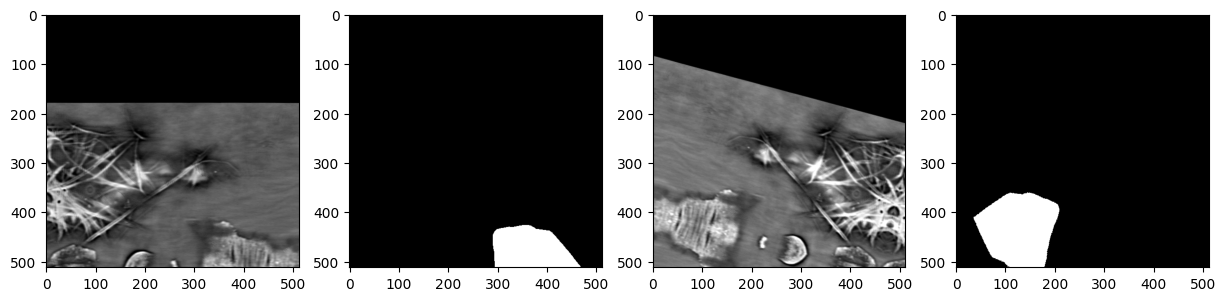

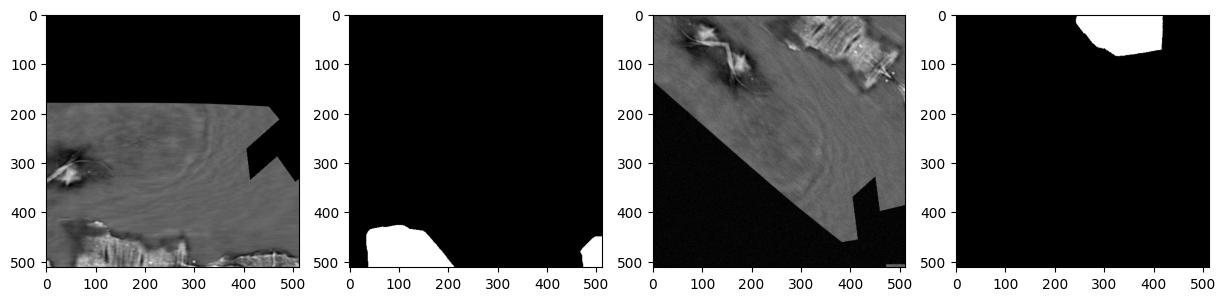

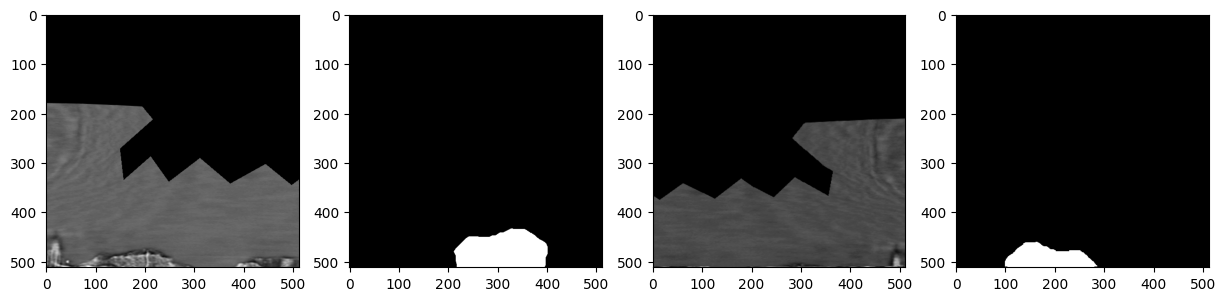

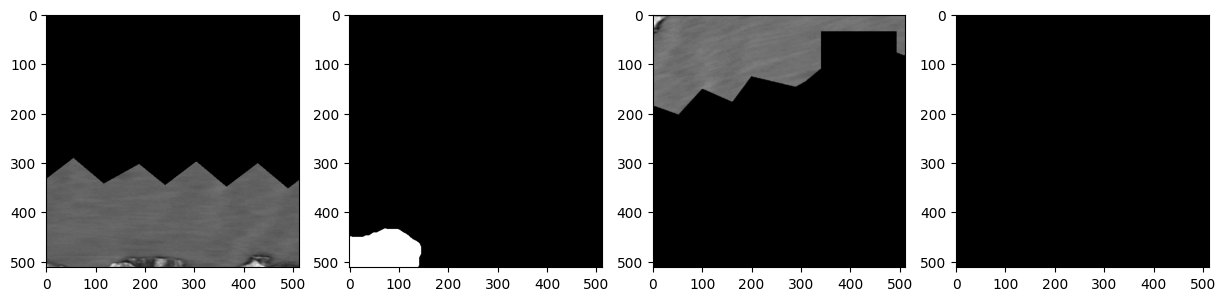

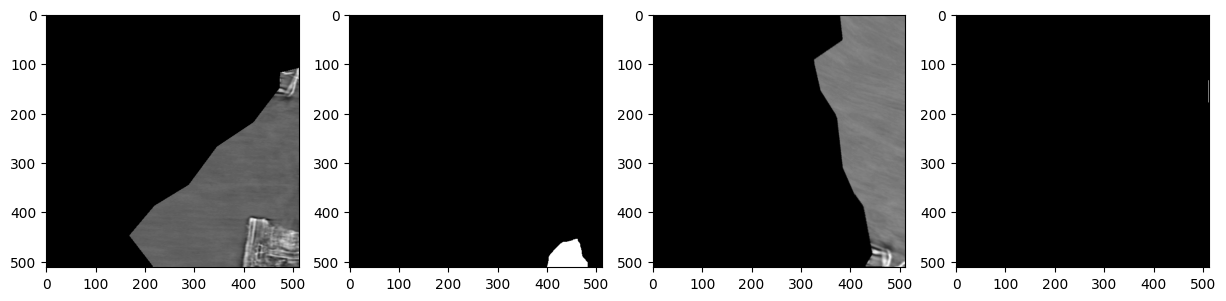

In [20]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [21]:
del plot_dataset
gc.collect()

50700

## model

In [22]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

## scheduler

In [23]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [24]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone efficientnet-b0


## loss

In [25]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    bce_loss =  BCELoss(y_pred, y_true)
    return bce_loss
    
    y_preds_probas = torch.sigmoid(y_pred)
    dxx = torch.pow(torch.roll(y_preds_probas, shifts=-1, dims=-1) - 2*y_preds_probas + torch.roll(y_preds_probas, shifts=1, dims=-2), 2)
    dyy = torch.pow(torch.roll(y_preds_probas, shifts=-1, dims=-2) - 2*y_preds_probas + torch.roll(y_preds_probas, shifts=1, dims=-2), 2)

    # Average over all pixels
    kin_energy = torch.mean(dxx + dyy)

    
    return bce_loss + kin_energy
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [26]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [27]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 100+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [28]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [29]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.11947802841261307
th: 0.15, fbeta: 0.11947804338459012
th: 0.2, fbeta: 0.11947847493219982
th: 0.25, fbeta: 0.11948014325150595
th: 0.3, fbeta: 0.11947718452995677
th: 0.35, fbeta: 0.11922141146284851
th: 0.4, fbeta: 0.11805270559100824
th: 0.45, fbeta: 0.11410645626510463
th: 0.5, fbeta: 0.2119605936659133
th: 0.55, fbeta: 0.21200284841362654
th: 0.6, fbeta: 0.19378804566986652
th: 0.65, fbeta: 0.1449453164602357
th: 0.7, fbeta: 0.06765710706257365
th: 0.75, fbeta: 0.01835228552807006
th: 0.8, fbeta: 0.003696748593638035
th: 0.85, fbeta: 0.0005094684180027422
th: 0.9, fbeta: 4.2131032560376027e-05
th: 0.95, fbeta: 0.0


best_th: 0.55, fbeta: 0.21200284841362654
Epoch 1 - avg_train_loss: 0.7870  avg_val_loss: 0.7084  time: 84s
Epoch 1 - avgScore: 0.2120
Epoch 1 - Save Best Score: 0.2120 Model
Epoch 1 - Save Best Loss: 0.7084 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1194780285744296
th: 0.15, fbeta: 0.11947760450453035
th: 0.2, fbeta: 0.11947368599540031
th: 0.25, fbeta: 0.1195384946426162
th: 0.3, fbeta: 0.12013136531514909
th: 0.35, fbeta: 0.11903941671127721
th: 0.4, fbeta: 0.11287104392823849
th: 0.45, fbeta: 0.10788758262775226
th: 0.5, fbeta: 0.21651716781965138
th: 0.55, fbeta: 0.2071249692289524
th: 0.6, fbeta: 0.16947973596447297
th: 0.65, fbeta: 0.10301454270084992
th: 0.7, fbeta: 0.04196684331838926
th: 0.75, fbeta: 0.013250499329111699
th: 0.8, fbeta: 0.003651547135460079
th: 0.85, fbeta: 0.0008283465455142301
th: 0.9, fbeta: 0.00011231923624175742
th: 0.95, fbeta: 2.8090079469871533e-06


best_th: 0.5, fbeta: 0.21651716781965138
Epoch 2 - avg_train_loss: 0.6891  avg_val_loss: 0.6477  time: 29s
Epoch 2 - avgScore: 0.2165
Epoch 2 - Save Best Score: 0.2165 Model
Epoch 2 - Save Best Loss: 0.6477 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.1335703717381925
th: 0.15, fbeta: 0.3034375580736772
th: 0.2, fbeta: 0.39262029833822293
th: 0.25, fbeta: 0.44365192917809665
th: 0.3, fbeta: 0.4484879101388355
th: 0.35, fbeta: 0.4420891993183404
th: 0.4, fbeta: 0.42315829730492893
th: 0.45, fbeta: 0.39547348569695756
th: 0.5, fbeta: 0.3657590109001358
th: 0.55, fbeta: 0.32846054697412913
th: 0.6, fbeta: 0.2824954809426387
th: 0.65, fbeta: 0.23590862874047697
th: 0.7, fbeta: 0.19937322287897338
th: 0.75, fbeta: 0.17233905066799968
th: 0.8, fbeta: 0.14538464845187551
th: 0.85, fbeta: 0.11817584922772371
th: 0.9, fbeta: 0.09715824920093444
th: 0.95, fbeta: 0.07349324365463844


best_th: 0.3, fbeta: 0.4484879101388355
Epoch 3 - avg_train_loss: 0.4373  avg_val_loss: 0.2928  time: 27s
Epoch 3 - avgScore: 0.4485
Epoch 3 - Save Best Score: 0.4485 Model
Epoch 3 - Save Best Loss: 0.2928 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26278517883514635
th: 0.15, fbeta: 0.3057740262548625
th: 0.2, fbeta: 0.3320531117483477
th: 0.25, fbeta: 0.35781593336247064
th: 0.3, fbeta: 0.3842165705031698
th: 0.35, fbeta: 0.40731384658746533
th: 0.4, fbeta: 0.42604859699731557
th: 0.45, fbeta: 0.4373168540698706
th: 0.5, fbeta: 0.44065349897699735
th: 0.55, fbeta: 0.4320072121396259
th: 0.6, fbeta: 0.40598566461127245
th: 0.65, fbeta: 0.3707280727216589
th: 0.7, fbeta: 0.33344849547885175
th: 0.75, fbeta: 0.29298665796548906
th: 0.8, fbeta: 0.24957489981843886
th: 0.85, fbeta: 0.21129808329845154
th: 0.9, fbeta: 0.1722215595130681
th: 0.95, fbeta: 0.12728850788871512


best_th: 0.5, fbeta: 0.44065349897699735
Epoch 4 - avg_train_loss: 0.2881  avg_val_loss: 0.2721  time: 29s
Epoch 4 - avgScore: 0.4407


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3255304058800836
th: 0.15, fbeta: 0.3670924987969904
th: 0.2, fbeta: 0.39445816950484025
th: 0.25, fbeta: 0.4147903782114569
th: 0.3, fbeta: 0.4307862271610703
th: 0.35, fbeta: 0.44337687392658875
th: 0.4, fbeta: 0.4509199688148453
th: 0.45, fbeta: 0.4548782438626403
th: 0.5, fbeta: 0.45247633576773927
th: 0.55, fbeta: 0.4403440612679656
th: 0.6, fbeta: 0.41980665382459986
th: 0.65, fbeta: 0.3921546636338116
th: 0.7, fbeta: 0.3601769065337398
th: 0.75, fbeta: 0.3265629500538635
th: 0.8, fbeta: 0.296831533456753
th: 0.85, fbeta: 0.26621225853616676
th: 0.9, fbeta: 0.23600327266016974
th: 0.95, fbeta: 0.19962818595395884


best_th: 0.45, fbeta: 0.4548782438626403
Epoch 5 - avg_train_loss: 0.2527  avg_val_loss: 0.2605  time: 27s
Epoch 5 - avgScore: 0.4549
Epoch 5 - Save Best Score: 0.4549 Model
Epoch 5 - Save Best Loss: 0.2605 Model


th: 1.0, fbeta: 9.269712265117589e-05


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3400456056959943
th: 0.15, fbeta: 0.3927921253977769
th: 0.2, fbeta: 0.4384273583706864
th: 0.25, fbeta: 0.4706889047878909
th: 0.3, fbeta: 0.4855566942686125
th: 0.35, fbeta: 0.48728576119227696
th: 0.4, fbeta: 0.48425957812742576
th: 0.45, fbeta: 0.47706815451363516
th: 0.5, fbeta: 0.46400229679465216
th: 0.55, fbeta: 0.4475579926269229
th: 0.6, fbeta: 0.4280514005083642
th: 0.65, fbeta: 0.4019362780512728
th: 0.7, fbeta: 0.36896577088200905
th: 0.75, fbeta: 0.3270544071386845
th: 0.8, fbeta: 0.2831907328381082
th: 0.85, fbeta: 0.23873091658527806
th: 0.9, fbeta: 0.19898397811012916
th: 0.95, fbeta: 0.15567259145534568


best_th: 0.35, fbeta: 0.48728576119227696
Epoch 6 - avg_train_loss: 0.2376  avg_val_loss: 0.2441  time: 27s
Epoch 6 - avgScore: 0.4873
Epoch 6 - Save Best Score: 0.4873 Model
Epoch 6 - Save Best Loss: 0.2441 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33292256920332325
th: 0.15, fbeta: 0.3719214951460914
th: 0.2, fbeta: 0.40036614420572547
th: 0.25, fbeta: 0.42421973467539886
th: 0.3, fbeta: 0.44602715366563167
th: 0.35, fbeta: 0.46605805197484873
th: 0.4, fbeta: 0.4765194667076983
th: 0.45, fbeta: 0.47731678592308624
th: 0.5, fbeta: 0.47046551688514143
th: 0.55, fbeta: 0.4574429783687013
th: 0.6, fbeta: 0.4373555083754891
th: 0.65, fbeta: 0.4066579548274448
th: 0.7, fbeta: 0.3653375900806012
th: 0.75, fbeta: 0.31502405978382786
th: 0.8, fbeta: 0.26667565212742533
th: 0.85, fbeta: 0.21758943777476666
th: 0.9, fbeta: 0.16531615040663467
th: 0.95, fbeta: 0.09119170479367229


best_th: 0.45, fbeta: 0.47731678592308624
Epoch 7 - avg_train_loss: 0.2281  avg_val_loss: 0.2460  time: 27s
Epoch 7 - avgScore: 0.4773


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33082801785685445
th: 0.15, fbeta: 0.35904000758747806
th: 0.2, fbeta: 0.37817603018082496
th: 0.25, fbeta: 0.3944538235221732
th: 0.3, fbeta: 0.4087920096442817
th: 0.35, fbeta: 0.42160284290562927
th: 0.4, fbeta: 0.43179333754140237
th: 0.45, fbeta: 0.44024103893456745
th: 0.5, fbeta: 0.44689116439379406
th: 0.55, fbeta: 0.4486423547995334
th: 0.6, fbeta: 0.44573850070205656
th: 0.65, fbeta: 0.4324710238226711
th: 0.7, fbeta: 0.4074567969786068
th: 0.75, fbeta: 0.3707558825813786
th: 0.8, fbeta: 0.3246827968555385
th: 0.85, fbeta: 0.26913618906462994
th: 0.9, fbeta: 0.20599849654668184
th: 0.95, fbeta: 0.12213605528317777


best_th: 0.55, fbeta: 0.4486423547995334
Epoch 8 - avg_train_loss: 0.2199  avg_val_loss: 0.2578  time: 27s
Epoch 8 - avgScore: 0.4486


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4211572383418632
th: 0.15, fbeta: 0.44861894212514425
th: 0.2, fbeta: 0.4632975576512726
th: 0.25, fbeta: 0.4724552605907143
th: 0.3, fbeta: 0.4696099101439389
th: 0.35, fbeta: 0.4608479595136104
th: 0.4, fbeta: 0.4525455157082354
th: 0.45, fbeta: 0.4413937834296
th: 0.5, fbeta: 0.4257778657797127
th: 0.55, fbeta: 0.40707360785416197
th: 0.6, fbeta: 0.38420109265969404
th: 0.65, fbeta: 0.35392196835146583
th: 0.7, fbeta: 0.319229352747973
th: 0.75, fbeta: 0.27793168252799705
th: 0.8, fbeta: 0.2321043117809113
th: 0.85, fbeta: 0.17737823651337536
th: 0.9, fbeta: 0.10704206323694655
th: 0.95, fbeta: 0.04220932660326547


best_th: 0.25, fbeta: 0.4724552605907143
Epoch 9 - avg_train_loss: 0.2103  avg_val_loss: 0.2737  time: 27s
Epoch 9 - avgScore: 0.4725


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32363588449853264
th: 0.15, fbeta: 0.34843894475197384
th: 0.2, fbeta: 0.3709533066984447
th: 0.25, fbeta: 0.3926354788391282
th: 0.3, fbeta: 0.4118474733550105
th: 0.35, fbeta: 0.4297336948846237
th: 0.4, fbeta: 0.4461888534007116
th: 0.45, fbeta: 0.4586033196183971
th: 0.5, fbeta: 0.4685119880503541
th: 0.55, fbeta: 0.4749138487372509
th: 0.6, fbeta: 0.47590669194498786
th: 0.65, fbeta: 0.4665212956510245
th: 0.7, fbeta: 0.441215665003675
th: 0.75, fbeta: 0.39881474318913607
th: 0.8, fbeta: 0.3405397320300555
th: 0.85, fbeta: 0.25191561684789526
th: 0.9, fbeta: 0.1457300183529745
th: 0.95, fbeta: 0.044653059038698636


best_th: 0.6, fbeta: 0.47590669194498786
Epoch 10 - avg_train_loss: 0.2062  avg_val_loss: 0.2584  time: 27s
Epoch 10 - avgScore: 0.4759


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33763938817823985
th: 0.15, fbeta: 0.3563985183750674
th: 0.2, fbeta: 0.36633658761207766
th: 0.25, fbeta: 0.3743279952158058
th: 0.3, fbeta: 0.37892397513369036
th: 0.35, fbeta: 0.38332786702159344
th: 0.4, fbeta: 0.386633651363314
th: 0.45, fbeta: 0.38664231882952044
th: 0.5, fbeta: 0.38271149718602804
th: 0.55, fbeta: 0.3769625504361529
th: 0.6, fbeta: 0.3674572566845062
th: 0.65, fbeta: 0.35152149981039765
th: 0.7, fbeta: 0.32630223983069767
th: 0.75, fbeta: 0.2908074719376344
th: 0.8, fbeta: 0.24206746335670076
th: 0.85, fbeta: 0.17228097063053252
th: 0.9, fbeta: 0.09272107814193191
th: 0.95, fbeta: 0.027679708928078056


best_th: 0.45, fbeta: 0.38664231882952044
Epoch 11 - avg_train_loss: 0.2001  avg_val_loss: 0.2837  time: 27s
Epoch 11 - avgScore: 0.3866


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4034360207875776
th: 0.15, fbeta: 0.42483742956233617
th: 0.2, fbeta: 0.4334231878915981
th: 0.25, fbeta: 0.43424048153999745
th: 0.3, fbeta: 0.43128928140362116
th: 0.35, fbeta: 0.4289911687092398
th: 0.4, fbeta: 0.4235724570916717
th: 0.45, fbeta: 0.41345345292936453
th: 0.5, fbeta: 0.4015812364315789
th: 0.55, fbeta: 0.38889131294515156
th: 0.6, fbeta: 0.3707283582947976
th: 0.65, fbeta: 0.3454233725363049
th: 0.7, fbeta: 0.31401518841290355
th: 0.75, fbeta: 0.27631135857387795
th: 0.8, fbeta: 0.226192236013824
th: 0.85, fbeta: 0.17017495674503103
th: 0.9, fbeta: 0.11091421261667504
th: 0.95, fbeta: 0.04273018296500366


best_th: 0.25, fbeta: 0.43424048153999745
Epoch 12 - avg_train_loss: 0.1926  avg_val_loss: 0.2946  time: 27s
Epoch 12 - avgScore: 0.4342


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3768715099630845
th: 0.15, fbeta: 0.40307844379613356
th: 0.2, fbeta: 0.42226802235182626
th: 0.25, fbeta: 0.43761862849341837
th: 0.3, fbeta: 0.4502953355158335
th: 0.35, fbeta: 0.4598701552639316
th: 0.4, fbeta: 0.46582763131536414
th: 0.45, fbeta: 0.46754216136131355
th: 0.5, fbeta: 0.4656289938056511
th: 0.55, fbeta: 0.46104428496825184
th: 0.6, fbeta: 0.45401772568301674
th: 0.65, fbeta: 0.43842971584929297
th: 0.7, fbeta: 0.4135318577835588
th: 0.75, fbeta: 0.3789355548835275
th: 0.8, fbeta: 0.3340503465360665
th: 0.85, fbeta: 0.2787780078214162
th: 0.9, fbeta: 0.2049101525346687
th: 0.95, fbeta: 0.12710435800657488


best_th: 0.45, fbeta: 0.46754216136131355
Epoch 13 - avg_train_loss: 0.1900  avg_val_loss: 0.2606  time: 27s
Epoch 13 - avgScore: 0.4675


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43445319616303074
th: 0.15, fbeta: 0.4641513847182245
th: 0.2, fbeta: 0.4855511044498275
th: 0.25, fbeta: 0.4975457880898986
th: 0.3, fbeta: 0.5022275043096542
th: 0.35, fbeta: 0.5044357659524163
th: 0.4, fbeta: 0.502518631467027
th: 0.45, fbeta: 0.49643219018858276
th: 0.5, fbeta: 0.48666211831763756
th: 0.55, fbeta: 0.4746701125572491
th: 0.6, fbeta: 0.45901400628241107
th: 0.65, fbeta: 0.4404972941535896
th: 0.7, fbeta: 0.4172876134360672
th: 0.75, fbeta: 0.388414787949844
th: 0.8, fbeta: 0.35266968610597793
th: 0.85, fbeta: 0.30784766561568405
th: 0.9, fbeta: 0.24918629366252873
th: 0.95, fbeta: 0.17089388772294253


best_th: 0.35, fbeta: 0.5044357659524163
Epoch 14 - avg_train_loss: 0.1831  avg_val_loss: 0.2811  time: 27s
Epoch 14 - avgScore: 0.5044
Epoch 14 - Save Best Score: 0.5044 Model
Epoch 14 - Save Best Loss: 0.2811 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3630967269095863
th: 0.15, fbeta: 0.3877113877596718
th: 0.2, fbeta: 0.4080772776624048
th: 0.25, fbeta: 0.4236495290567859
th: 0.3, fbeta: 0.4377510485631507
th: 0.35, fbeta: 0.4519761724707391
th: 0.4, fbeta: 0.46289655779005273
th: 0.45, fbeta: 0.4704917048262244
th: 0.5, fbeta: 0.47420905221933285
th: 0.55, fbeta: 0.4741349616509428
th: 0.6, fbeta: 0.4688110583687244
th: 0.65, fbeta: 0.45730074514791
th: 0.7, fbeta: 0.4398248184606408
th: 0.75, fbeta: 0.4110189644073262
th: 0.8, fbeta: 0.36146677409375727
th: 0.85, fbeta: 0.28082523451716573
th: 0.9, fbeta: 0.17584729681067035
th: 0.95, fbeta: 0.04990427358067572


best_th: 0.5, fbeta: 0.47420905221933285
Epoch 15 - avg_train_loss: 0.1786  avg_val_loss: 0.2624  time: 27s
Epoch 15 - avgScore: 0.4742


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41062094547782374
th: 0.15, fbeta: 0.4321917724669187
th: 0.2, fbeta: 0.4482691760661884
th: 0.25, fbeta: 0.45799961140386897
th: 0.3, fbeta: 0.460980416765118
th: 0.35, fbeta: 0.4600146443871215
th: 0.4, fbeta: 0.4550381076988369
th: 0.45, fbeta: 0.4481212290419621
th: 0.5, fbeta: 0.4396158793981752
th: 0.55, fbeta: 0.42999864508052127
th: 0.6, fbeta: 0.41784134927182875
th: 0.65, fbeta: 0.4035778859039892
th: 0.7, fbeta: 0.38220759981846175
th: 0.75, fbeta: 0.354580940388823
th: 0.8, fbeta: 0.31337118843881967
th: 0.85, fbeta: 0.2564624519672567
th: 0.9, fbeta: 0.18039435895606232
th: 0.95, fbeta: 0.08755779735705853


best_th: 0.3, fbeta: 0.460980416765118
Epoch 16 - avg_train_loss: 0.1748  avg_val_loss: 0.2942  time: 27s
Epoch 16 - avgScore: 0.4610


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41795837383289763
th: 0.15, fbeta: 0.44291815714178495
th: 0.2, fbeta: 0.4635349797152186
th: 0.25, fbeta: 0.48053892741072435
th: 0.3, fbeta: 0.4911225258556283
th: 0.35, fbeta: 0.49831289092041153
th: 0.4, fbeta: 0.5043683352759227
th: 0.45, fbeta: 0.5061137268123068
th: 0.5, fbeta: 0.5029704243267995
th: 0.55, fbeta: 0.4967348488415215
th: 0.6, fbeta: 0.4881749244913879
th: 0.65, fbeta: 0.4770384853261712
th: 0.7, fbeta: 0.462997420743417
th: 0.75, fbeta: 0.4430646554617395
th: 0.8, fbeta: 0.4186971432484665
th: 0.85, fbeta: 0.3833161358749665
th: 0.9, fbeta: 0.3246389369107429
th: 0.95, fbeta: 0.2292414564360546


best_th: 0.45, fbeta: 0.5061137268123068
Epoch 17 - avg_train_loss: 0.1685  avg_val_loss: 0.2841  time: 27s
Epoch 17 - avgScore: 0.5061
Epoch 17 - Save Best Score: 0.5061 Model
Epoch 17 - Save Best Loss: 0.2841 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40273562089324133
th: 0.15, fbeta: 0.4321610053427576
th: 0.2, fbeta: 0.45516372772340374
th: 0.25, fbeta: 0.47206531857786105
th: 0.3, fbeta: 0.4866589954097347
th: 0.35, fbeta: 0.4963083910305957
th: 0.4, fbeta: 0.5025507292515657
th: 0.45, fbeta: 0.5017277592894832
th: 0.5, fbeta: 0.49835603799967315
th: 0.55, fbeta: 0.49399809116503285
th: 0.6, fbeta: 0.48761318072817117
th: 0.65, fbeta: 0.4780028189560445
th: 0.7, fbeta: 0.4647771073876361
th: 0.75, fbeta: 0.44669236976271476
th: 0.8, fbeta: 0.4189394054157072
th: 0.85, fbeta: 0.38012539371840004
th: 0.9, fbeta: 0.3209078564364677
th: 0.95, fbeta: 0.2338531033684576


best_th: 0.4, fbeta: 0.5025507292515657
Epoch 18 - avg_train_loss: 0.1664  avg_val_loss: 0.2681  time: 32s
Epoch 18 - avgScore: 0.5026


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4049731425119912
th: 0.15, fbeta: 0.43476291391788124
th: 0.2, fbeta: 0.4544015972010611
th: 0.25, fbeta: 0.47028450051127446
th: 0.3, fbeta: 0.48465220361584294
th: 0.35, fbeta: 0.4966411917542216
th: 0.4, fbeta: 0.5050010576683521
th: 0.45, fbeta: 0.5101419588596446
th: 0.5, fbeta: 0.5119525802421527
th: 0.55, fbeta: 0.5107816571796588
th: 0.6, fbeta: 0.5057910998317274
th: 0.65, fbeta: 0.49652640239219364
th: 0.7, fbeta: 0.4778601520412929
th: 0.75, fbeta: 0.4502688513922852
th: 0.8, fbeta: 0.4082519872405347
th: 0.85, fbeta: 0.3475203222412564
th: 0.9, fbeta: 0.2519134694752428
th: 0.95, fbeta: 0.10856673899876665


best_th: 0.5, fbeta: 0.5119525802421527
Epoch 19 - avg_train_loss: 0.1603  avg_val_loss: 0.2516  time: 29s
Epoch 19 - avgScore: 0.5120
Epoch 19 - Save Best Score: 0.5120 Model
Epoch 19 - Save Best Loss: 0.2516 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3531664905946142
th: 0.15, fbeta: 0.3776929728939268
th: 0.2, fbeta: 0.3966151182964235
th: 0.25, fbeta: 0.4130472709745718
th: 0.3, fbeta: 0.42677960696337625
th: 0.35, fbeta: 0.4401549339626298
th: 0.4, fbeta: 0.45248777522732603
th: 0.45, fbeta: 0.4631733991536307
th: 0.5, fbeta: 0.47121905540279746
th: 0.55, fbeta: 0.47697683479167957
th: 0.6, fbeta: 0.48006611099590507
th: 0.65, fbeta: 0.4818739987711119
th: 0.7, fbeta: 0.4810804423146701
th: 0.75, fbeta: 0.4762789360603772
th: 0.8, fbeta: 0.464505292063618
th: 0.85, fbeta: 0.4362799669050863
th: 0.9, fbeta: 0.37488759281757095
th: 0.95, fbeta: 0.24151831046955607


best_th: 0.65, fbeta: 0.4818739987711119
Epoch 20 - avg_train_loss: 0.1594  avg_val_loss: 0.2814  time: 29s
Epoch 20 - avgScore: 0.4819


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3909867723309892
th: 0.15, fbeta: 0.4128346863725927
th: 0.2, fbeta: 0.4312397961520289
th: 0.25, fbeta: 0.44699633851483106
th: 0.3, fbeta: 0.45939855378369615
th: 0.35, fbeta: 0.4678920409276423
th: 0.4, fbeta: 0.47367371708785144
th: 0.45, fbeta: 0.47980230407659097
th: 0.5, fbeta: 0.4854289006904457
th: 0.55, fbeta: 0.48933341534623104
th: 0.6, fbeta: 0.4893644215787927
th: 0.65, fbeta: 0.4865761861565124
th: 0.7, fbeta: 0.4778117688587978
th: 0.75, fbeta: 0.46251320927841266
th: 0.8, fbeta: 0.4357007816053825
th: 0.85, fbeta: 0.39576646754397043
th: 0.9, fbeta: 0.33618408103955455
th: 0.95, fbeta: 0.23582479714999388


best_th: 0.6, fbeta: 0.4893644215787927
Epoch 21 - avg_train_loss: 0.1540  avg_val_loss: 0.2814  time: 29s
Epoch 21 - avgScore: 0.4894


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39010629261863133
th: 0.15, fbeta: 0.4183181197666202
th: 0.2, fbeta: 0.438002900616449
th: 0.25, fbeta: 0.45109703093238906
th: 0.3, fbeta: 0.45982183687827777
th: 0.35, fbeta: 0.4679663652926532
th: 0.4, fbeta: 0.47505345145700006
th: 0.45, fbeta: 0.48033746252834714
th: 0.5, fbeta: 0.48518658595895925
th: 0.55, fbeta: 0.48717983319573877
th: 0.6, fbeta: 0.48660095783355434
th: 0.65, fbeta: 0.4825869003726128
th: 0.7, fbeta: 0.4728678100419242
th: 0.75, fbeta: 0.4565283362350126
th: 0.8, fbeta: 0.42943129694624854
th: 0.85, fbeta: 0.38675445325030683
th: 0.9, fbeta: 0.3078483417202641
th: 0.95, fbeta: 0.1847890701086697


best_th: 0.55, fbeta: 0.48717983319573877
Epoch 22 - avg_train_loss: 0.1524  avg_val_loss: 0.2684  time: 27s
Epoch 22 - avgScore: 0.4872


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42561651846096954
th: 0.15, fbeta: 0.45409804638172296
th: 0.2, fbeta: 0.4733973651444615
th: 0.25, fbeta: 0.4892411614894466
th: 0.3, fbeta: 0.5012442774682399
th: 0.35, fbeta: 0.5077650735473079
th: 0.4, fbeta: 0.5124081169166617
th: 0.45, fbeta: 0.5161412816091253
th: 0.5, fbeta: 0.5195408277803997
th: 0.55, fbeta: 0.5186305551551331
th: 0.6, fbeta: 0.5137483275563809
th: 0.65, fbeta: 0.5063706299820974
th: 0.7, fbeta: 0.49655072550748386
th: 0.75, fbeta: 0.48233727528160314
th: 0.8, fbeta: 0.46242376073713065
th: 0.85, fbeta: 0.43265897484100796
th: 0.9, fbeta: 0.38389430403248753
th: 0.95, fbeta: 0.29706264085708417


best_th: 0.5, fbeta: 0.5195408277803997
Epoch 23 - avg_train_loss: 0.1476  avg_val_loss: 0.2802  time: 30s
Epoch 23 - avgScore: 0.5195
Epoch 23 - Save Best Score: 0.5195 Model
Epoch 23 - Save Best Loss: 0.2802 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44632458195383556
th: 0.15, fbeta: 0.46789111254735244
th: 0.2, fbeta: 0.48565460774025593
th: 0.25, fbeta: 0.498356874384911
th: 0.3, fbeta: 0.5054235284856297
th: 0.35, fbeta: 0.5091480036625212
th: 0.4, fbeta: 0.5081647739309033
th: 0.45, fbeta: 0.5029531139712822
th: 0.5, fbeta: 0.4969496056014115
th: 0.55, fbeta: 0.48794111099737053
th: 0.6, fbeta: 0.47549261793305947
th: 0.65, fbeta: 0.4591675260471377
th: 0.7, fbeta: 0.4401984204347726
th: 0.75, fbeta: 0.42051060743697805
th: 0.8, fbeta: 0.39423826318758126
th: 0.85, fbeta: 0.3579849161628838
th: 0.9, fbeta: 0.3083125074643025
th: 0.95, fbeta: 0.23228419253498486


best_th: 0.35, fbeta: 0.5091480036625212
Epoch 24 - avg_train_loss: 0.1458  avg_val_loss: 0.3054  time: 27s
Epoch 24 - avgScore: 0.5091


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4288763962584338
th: 0.15, fbeta: 0.45165975566359057
th: 0.2, fbeta: 0.47134623398344233
th: 0.25, fbeta: 0.48698328694622917
th: 0.3, fbeta: 0.4988110103833513
th: 0.35, fbeta: 0.506207793932614
th: 0.4, fbeta: 0.5083670141088188
th: 0.45, fbeta: 0.5088056916244034
th: 0.5, fbeta: 0.507299008693716
th: 0.55, fbeta: 0.5040280263828697
th: 0.6, fbeta: 0.49898852612551076
th: 0.65, fbeta: 0.49136075824662356
th: 0.7, fbeta: 0.480368240850095
th: 0.75, fbeta: 0.46601174079064417
th: 0.8, fbeta: 0.44466417550345066
th: 0.85, fbeta: 0.41267431820755934
th: 0.9, fbeta: 0.3685770755008457
th: 0.95, fbeta: 0.29083925476208217


best_th: 0.45, fbeta: 0.5088056916244034
Epoch 25 - avg_train_loss: 0.1409  avg_val_loss: 0.2908  time: 27s
Epoch 25 - avgScore: 0.5088


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4273060213405438
th: 0.15, fbeta: 0.44987690182048556
th: 0.2, fbeta: 0.4644916335669286
th: 0.25, fbeta: 0.47536266980516045
th: 0.3, fbeta: 0.48291661294410343
th: 0.35, fbeta: 0.4891945687452414
th: 0.4, fbeta: 0.4945187069928389
th: 0.45, fbeta: 0.4963641308861077
th: 0.5, fbeta: 0.49491636091710267
th: 0.55, fbeta: 0.4905561382501822
th: 0.6, fbeta: 0.4799279624377537
th: 0.65, fbeta: 0.4649751872406461
th: 0.7, fbeta: 0.4462231586525359
th: 0.75, fbeta: 0.422458769432525
th: 0.8, fbeta: 0.38996476778087236
th: 0.85, fbeta: 0.34643591336417123
th: 0.9, fbeta: 0.2815883858679119
th: 0.95, fbeta: 0.17969507288264322


best_th: 0.45, fbeta: 0.4963641308861077
Epoch 26 - avg_train_loss: 0.1392  avg_val_loss: 0.2977  time: 27s
Epoch 26 - avgScore: 0.4964


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42435269609842724
th: 0.15, fbeta: 0.4445801028423592
th: 0.2, fbeta: 0.4613167060589693
th: 0.25, fbeta: 0.47545794664205293
th: 0.3, fbeta: 0.48372816158449145
th: 0.35, fbeta: 0.48764456171168447
th: 0.4, fbeta: 0.4882414967788085
th: 0.45, fbeta: 0.4850279946468231
th: 0.5, fbeta: 0.4790512057939941
th: 0.55, fbeta: 0.46913931697078215
th: 0.6, fbeta: 0.4570183123160848
th: 0.65, fbeta: 0.44126166456774396
th: 0.7, fbeta: 0.4192514018008863
th: 0.75, fbeta: 0.38963613258393076
th: 0.8, fbeta: 0.3509412542950788
th: 0.85, fbeta: 0.30345753743671333
th: 0.9, fbeta: 0.24166111773861496
th: 0.95, fbeta: 0.15296610523761067


best_th: 0.4, fbeta: 0.4882414967788085
Epoch 27 - avg_train_loss: 0.1376  avg_val_loss: 0.2902  time: 28s
Epoch 27 - avgScore: 0.4882


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42877858044321593
th: 0.15, fbeta: 0.4493500764224751
th: 0.2, fbeta: 0.466334009886161
th: 0.25, fbeta: 0.48210667885697683
th: 0.3, fbeta: 0.4933712129982522
th: 0.35, fbeta: 0.5008829569335328
th: 0.4, fbeta: 0.5063255770211332
th: 0.45, fbeta: 0.5063410421540495
th: 0.5, fbeta: 0.5038184436712279
th: 0.55, fbeta: 0.5000762801608327
th: 0.6, fbeta: 0.49345930807362776
th: 0.65, fbeta: 0.483977237131892
th: 0.7, fbeta: 0.47022297260722756
th: 0.75, fbeta: 0.45084541849333043
th: 0.8, fbeta: 0.4219569911038389
th: 0.85, fbeta: 0.3801491801761657
th: 0.9, fbeta: 0.31396923055975146
th: 0.95, fbeta: 0.2060236977500634


best_th: 0.45, fbeta: 0.5063410421540495
Epoch 28 - avg_train_loss: 0.1355  avg_val_loss: 0.3042  time: 27s
Epoch 28 - avgScore: 0.5063


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39186917075714534
th: 0.15, fbeta: 0.41370080660248915
th: 0.2, fbeta: 0.43023105690619856
th: 0.25, fbeta: 0.44469442695072775
th: 0.3, fbeta: 0.45640936979429125
th: 0.35, fbeta: 0.46649888601981265
th: 0.4, fbeta: 0.4762766453526666
th: 0.45, fbeta: 0.48613909577923614
th: 0.5, fbeta: 0.49689320579630375
th: 0.55, fbeta: 0.5043662537720413
th: 0.6, fbeta: 0.5073309830586902
th: 0.65, fbeta: 0.5053023722232576
th: 0.7, fbeta: 0.500162209154757
th: 0.75, fbeta: 0.4924143440383308
th: 0.8, fbeta: 0.47372114298535184
th: 0.85, fbeta: 0.4458288863672017
th: 0.9, fbeta: 0.39281887160977436
th: 0.95, fbeta: 0.29623104581912124


best_th: 0.6, fbeta: 0.5073309830586902
Epoch 29 - avg_train_loss: 0.1308  avg_val_loss: 0.2876  time: 27s
Epoch 29 - avgScore: 0.5073


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41268391869188475
th: 0.15, fbeta: 0.43382445178156503
th: 0.2, fbeta: 0.4533343747325544
th: 0.25, fbeta: 0.4705277438732778
th: 0.3, fbeta: 0.48335301225659655
th: 0.35, fbeta: 0.4908697998258189
th: 0.4, fbeta: 0.496152733367093
th: 0.45, fbeta: 0.49956163055431346
th: 0.5, fbeta: 0.4980992283026526
th: 0.55, fbeta: 0.49172033585359054
th: 0.6, fbeta: 0.4813540640050429
th: 0.65, fbeta: 0.4710385243114913
th: 0.7, fbeta: 0.4566188790440679
th: 0.75, fbeta: 0.43514639779126496
th: 0.8, fbeta: 0.4030292030204782
th: 0.85, fbeta: 0.3622951312526451
th: 0.9, fbeta: 0.3048317557457164
th: 0.95, fbeta: 0.20758072948160836


best_th: 0.45, fbeta: 0.49956163055431346
Epoch 30 - avg_train_loss: 0.1273  avg_val_loss: 0.3053  time: 27s
Epoch 30 - avgScore: 0.4996


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.462479564066534
th: 0.15, fbeta: 0.4809135632723891
th: 0.2, fbeta: 0.49273485047935023
th: 0.25, fbeta: 0.49946564556842904
th: 0.3, fbeta: 0.5021846594821224
th: 0.35, fbeta: 0.5018963342535997
th: 0.4, fbeta: 0.4980382371075456
th: 0.45, fbeta: 0.49103019631015177
th: 0.5, fbeta: 0.48444459858192196
th: 0.55, fbeta: 0.4776145397522654
th: 0.6, fbeta: 0.4666187222969194
th: 0.65, fbeta: 0.45163420225702305
th: 0.7, fbeta: 0.4330830617466702
th: 0.75, fbeta: 0.4084662824698144
th: 0.8, fbeta: 0.37938693597902173
th: 0.85, fbeta: 0.34168892932802514
th: 0.9, fbeta: 0.2890654764225437
th: 0.95, fbeta: 0.1989656308744967


best_th: 0.3, fbeta: 0.5021846594821224
Epoch 31 - avg_train_loss: 0.1313  avg_val_loss: 0.3401  time: 27s
Epoch 31 - avgScore: 0.5022


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4100735348008099
th: 0.15, fbeta: 0.43499513423781855
th: 0.2, fbeta: 0.4534574793943534
th: 0.25, fbeta: 0.467841048812313
th: 0.3, fbeta: 0.4791088514938034
th: 0.35, fbeta: 0.48928370428889034
th: 0.4, fbeta: 0.49872167679285506
th: 0.45, fbeta: 0.5048672014847136
th: 0.5, fbeta: 0.5069365008028274
th: 0.55, fbeta: 0.5062020234973482
th: 0.6, fbeta: 0.5035757332024615
th: 0.65, fbeta: 0.4976463862386759
th: 0.7, fbeta: 0.48778259218712755
th: 0.75, fbeta: 0.47094025660767924
th: 0.8, fbeta: 0.4465570342215175
th: 0.85, fbeta: 0.411274641929653
th: 0.9, fbeta: 0.3594064568862385
th: 0.95, fbeta: 0.2685136346722291


best_th: 0.5, fbeta: 0.5069365008028274
Epoch 32 - avg_train_loss: 0.1257  avg_val_loss: 0.2865  time: 27s
Epoch 32 - avgScore: 0.5069


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39537327522821386
th: 0.15, fbeta: 0.41814681180028834
th: 0.2, fbeta: 0.4354648826394555
th: 0.25, fbeta: 0.4484172724631563
th: 0.3, fbeta: 0.45955369776728117
th: 0.35, fbeta: 0.47021888304662635
th: 0.4, fbeta: 0.48091772573796293
th: 0.45, fbeta: 0.4907285263677365
th: 0.5, fbeta: 0.49977248172501404
th: 0.55, fbeta: 0.5067055435946531
th: 0.6, fbeta: 0.510427922428924
th: 0.65, fbeta: 0.509006858012745
th: 0.7, fbeta: 0.502134546769782
th: 0.75, fbeta: 0.4901980526823386
th: 0.8, fbeta: 0.4671806242907647
th: 0.85, fbeta: 0.42525956921656466
th: 0.9, fbeta: 0.3584371079794701
th: 0.95, fbeta: 0.24178598937414458


best_th: 0.6, fbeta: 0.510427922428924
Epoch 33 - avg_train_loss: 0.1224  avg_val_loss: 0.2818  time: 27s
Epoch 33 - avgScore: 0.5104


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4138721274175466
th: 0.15, fbeta: 0.4383445056566668
th: 0.2, fbeta: 0.4576781266205438
th: 0.25, fbeta: 0.47138611860385055
th: 0.3, fbeta: 0.48362639545294694
th: 0.35, fbeta: 0.4935859072390209
th: 0.4, fbeta: 0.502084715327764
th: 0.45, fbeta: 0.5093886513792903
th: 0.5, fbeta: 0.514729758754068
th: 0.55, fbeta: 0.5155199427016427
th: 0.6, fbeta: 0.5120125477356919
th: 0.65, fbeta: 0.5051511630911104
th: 0.7, fbeta: 0.49756484084289515
th: 0.75, fbeta: 0.48446051365257004
th: 0.8, fbeta: 0.46419724157042397
th: 0.85, fbeta: 0.4367318900121843
th: 0.9, fbeta: 0.38965795177822515
th: 0.95, fbeta: 0.30490654880897133


best_th: 0.55, fbeta: 0.5155199427016427
Epoch 34 - avg_train_loss: 0.1211  avg_val_loss: 0.2937  time: 27s
Epoch 34 - avgScore: 0.5155


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38598126790622056
th: 0.15, fbeta: 0.4076142455927604
th: 0.2, fbeta: 0.42394343467944784
th: 0.25, fbeta: 0.43678416178563256
th: 0.3, fbeta: 0.44815269758769527
th: 0.35, fbeta: 0.4588712258839559
th: 0.4, fbeta: 0.46862925971304575
th: 0.45, fbeta: 0.47710478357311464
th: 0.5, fbeta: 0.48397324636716754
th: 0.55, fbeta: 0.4886310824997177
th: 0.6, fbeta: 0.4898251284345305
th: 0.65, fbeta: 0.4888529171517093
th: 0.7, fbeta: 0.4848548334853121
th: 0.75, fbeta: 0.4732163890960078
th: 0.8, fbeta: 0.4551297870434406
th: 0.85, fbeta: 0.42624881687299154
th: 0.9, fbeta: 0.37379205646440883
th: 0.95, fbeta: 0.2776791156161065


best_th: 0.6, fbeta: 0.4898251284345305
Epoch 35 - avg_train_loss: 0.1195  avg_val_loss: 0.3048  time: 27s
Epoch 35 - avgScore: 0.4898


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4545546637878312
th: 0.15, fbeta: 0.47309413961069074
th: 0.2, fbeta: 0.48677663788337866
th: 0.25, fbeta: 0.4982678422302073
th: 0.3, fbeta: 0.5058819536257287
th: 0.35, fbeta: 0.5092039426987875
th: 0.4, fbeta: 0.5073736503301736
th: 0.45, fbeta: 0.5035813566161095
th: 0.5, fbeta: 0.49764779221854044
th: 0.55, fbeta: 0.4904638356833577
th: 0.6, fbeta: 0.48192947419838805
th: 0.65, fbeta: 0.4721075184790463
th: 0.7, fbeta: 0.45807550245326045
th: 0.75, fbeta: 0.4390537050192042
th: 0.8, fbeta: 0.4144661488553143
th: 0.85, fbeta: 0.3815076005507486
th: 0.9, fbeta: 0.33674906049638853
th: 0.95, fbeta: 0.26516844549953406


best_th: 0.35, fbeta: 0.5092039426987875
Epoch 36 - avg_train_loss: 0.1180  avg_val_loss: 0.3358  time: 27s
Epoch 36 - avgScore: 0.5092


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4298430748188541
th: 0.15, fbeta: 0.4480572590922094
th: 0.2, fbeta: 0.46256498521864653
th: 0.25, fbeta: 0.47411186028898705
th: 0.3, fbeta: 0.4819820652021823
th: 0.35, fbeta: 0.4877424062003395
th: 0.4, fbeta: 0.4898986741702558
th: 0.45, fbeta: 0.4918917518759246
th: 0.5, fbeta: 0.4925097081125324
th: 0.55, fbeta: 0.49117233952599165
th: 0.6, fbeta: 0.4871873473234159
th: 0.65, fbeta: 0.4793760091290363
th: 0.7, fbeta: 0.4677486635138703
th: 0.75, fbeta: 0.4529649404847822
th: 0.8, fbeta: 0.43140810894787585
th: 0.85, fbeta: 0.39555960925790207
th: 0.9, fbeta: 0.33980789498644143
th: 0.95, fbeta: 0.25295415340040317


best_th: 0.5, fbeta: 0.4925097081125324
Epoch 37 - avg_train_loss: 0.1144  avg_val_loss: 0.3054  time: 27s
Epoch 37 - avgScore: 0.4925


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42218011353884094
th: 0.15, fbeta: 0.44414091375314263
th: 0.2, fbeta: 0.4607574668077784
th: 0.25, fbeta: 0.4746280092641821
th: 0.3, fbeta: 0.48453691992164216
th: 0.35, fbeta: 0.4911772979527324
th: 0.4, fbeta: 0.4935024704825329
th: 0.45, fbeta: 0.49390464535155293
th: 0.5, fbeta: 0.4915327572485758
th: 0.55, fbeta: 0.486283121708465
th: 0.6, fbeta: 0.47905901760577707
th: 0.65, fbeta: 0.46795982198717784
th: 0.7, fbeta: 0.45040216774870073
th: 0.75, fbeta: 0.4271861752486932
th: 0.8, fbeta: 0.39508666990342756
th: 0.85, fbeta: 0.3527650734387582
th: 0.9, fbeta: 0.2984054202047057
th: 0.95, fbeta: 0.2181538219418576


best_th: 0.45, fbeta: 0.49390464535155293
Epoch 38 - avg_train_loss: 0.1111  avg_val_loss: 0.3102  time: 27s
Epoch 38 - avgScore: 0.4939


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.405482168217013
th: 0.15, fbeta: 0.42591667011092005
th: 0.2, fbeta: 0.4413753715189881
th: 0.25, fbeta: 0.45501244993366874
th: 0.3, fbeta: 0.46621703487489646
th: 0.35, fbeta: 0.4756221908017873
th: 0.4, fbeta: 0.48288367708325686
th: 0.45, fbeta: 0.48987668567268
th: 0.5, fbeta: 0.49319173847632825
th: 0.55, fbeta: 0.49348133119877685
th: 0.6, fbeta: 0.4917277085004055
th: 0.65, fbeta: 0.48876919996203394
th: 0.7, fbeta: 0.4830576481472487
th: 0.75, fbeta: 0.4724417575700292
th: 0.8, fbeta: 0.45489213782564536
th: 0.85, fbeta: 0.4295375821279196
th: 0.9, fbeta: 0.38527591529693744
th: 0.95, fbeta: 0.3046277484093488


best_th: 0.55, fbeta: 0.49348133119877685
Epoch 39 - avg_train_loss: 0.1108  avg_val_loss: 0.3092  time: 27s
Epoch 39 - avgScore: 0.4935


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.454393351820918
th: 0.15, fbeta: 0.4738779547789956
th: 0.2, fbeta: 0.4877010430910232
th: 0.25, fbeta: 0.4972519841499043
th: 0.3, fbeta: 0.5025500800830507
th: 0.35, fbeta: 0.5034554122779181
th: 0.4, fbeta: 0.5025873696581395
th: 0.45, fbeta: 0.49865357665480214
th: 0.5, fbeta: 0.4932427534041396
th: 0.55, fbeta: 0.483669863323255
th: 0.6, fbeta: 0.4662243537169545
th: 0.65, fbeta: 0.4450727088868116
th: 0.7, fbeta: 0.42052244903794567
th: 0.75, fbeta: 0.3895050598838413
th: 0.8, fbeta: 0.3521949173348349
th: 0.85, fbeta: 0.3104333457444076
th: 0.9, fbeta: 0.25780808812465383
th: 0.95, fbeta: 0.17503250460305844


best_th: 0.35, fbeta: 0.5034554122779181
Epoch 40 - avg_train_loss: 0.1091  avg_val_loss: 0.3325  time: 27s
Epoch 40 - avgScore: 0.5035


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4149208219858741
th: 0.15, fbeta: 0.4328626591714776
th: 0.2, fbeta: 0.4478186056192223
th: 0.25, fbeta: 0.46145805129058953
th: 0.3, fbeta: 0.4745121634118501
th: 0.35, fbeta: 0.484699042772717
th: 0.4, fbeta: 0.49243643465634784
th: 0.45, fbeta: 0.49697628856890136
th: 0.5, fbeta: 0.500483813945236
th: 0.55, fbeta: 0.5022269921538347
th: 0.6, fbeta: 0.5013069608371155
th: 0.65, fbeta: 0.49755129491785827
th: 0.7, fbeta: 0.48820849528755816
th: 0.75, fbeta: 0.47675763548109434
th: 0.8, fbeta: 0.46122194725368787
th: 0.85, fbeta: 0.43849409433257325
th: 0.9, fbeta: 0.4006219579498056
th: 0.95, fbeta: 0.3287636854178517


best_th: 0.55, fbeta: 0.5022269921538347
Epoch 41 - avg_train_loss: 0.1075  avg_val_loss: 0.3028  time: 27s
Epoch 41 - avgScore: 0.5022


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44431143250138616
th: 0.15, fbeta: 0.4646291997323695
th: 0.2, fbeta: 0.4792873708545216
th: 0.25, fbeta: 0.48898684085917055
th: 0.3, fbeta: 0.4969150494540449
th: 0.35, fbeta: 0.5021735107354447
th: 0.4, fbeta: 0.5045105510908624
th: 0.45, fbeta: 0.5043476149821361
th: 0.5, fbeta: 0.503160250670113
th: 0.55, fbeta: 0.49973930070651473
th: 0.6, fbeta: 0.49536386136929783
th: 0.65, fbeta: 0.4875977281154073
th: 0.7, fbeta: 0.4754423991592742
th: 0.75, fbeta: 0.4595249339374429
th: 0.8, fbeta: 0.4380317423834439
th: 0.85, fbeta: 0.40785355420570607
th: 0.9, fbeta: 0.3639275985031952
th: 0.95, fbeta: 0.2926225605075252


best_th: 0.4, fbeta: 0.5045105510908624
Epoch 42 - avg_train_loss: 0.1050  avg_val_loss: 0.3336  time: 27s
Epoch 42 - avgScore: 0.5045


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4398238627450671
th: 0.15, fbeta: 0.45963039407602285
th: 0.2, fbeta: 0.4724532490663933
th: 0.25, fbeta: 0.48168309157695927
th: 0.3, fbeta: 0.48937466418331305
th: 0.35, fbeta: 0.49431950636973615
th: 0.4, fbeta: 0.4972978887952387
th: 0.45, fbeta: 0.49863458377560266
th: 0.5, fbeta: 0.4973332361154067
th: 0.55, fbeta: 0.4934745660263169
th: 0.6, fbeta: 0.48541961014531976
th: 0.65, fbeta: 0.4750031630912629
th: 0.7, fbeta: 0.46051111686172597
th: 0.75, fbeta: 0.4387207539110532
th: 0.8, fbeta: 0.40809133316765706
th: 0.85, fbeta: 0.36819904870454695
th: 0.9, fbeta: 0.31571081957701413
th: 0.95, fbeta: 0.24035731393041967


best_th: 0.45, fbeta: 0.49863458377560266
Epoch 43 - avg_train_loss: 0.1042  avg_val_loss: 0.3429  time: 27s
Epoch 43 - avgScore: 0.4986


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43663573427213187
th: 0.15, fbeta: 0.45633891262871684
th: 0.2, fbeta: 0.47263514116631816
th: 0.25, fbeta: 0.48535757672454566
th: 0.3, fbeta: 0.4951528712653888
th: 0.35, fbeta: 0.5025889847476278
th: 0.4, fbeta: 0.5066393685671267
th: 0.45, fbeta: 0.5066676148653674
th: 0.5, fbeta: 0.505049216651197
th: 0.55, fbeta: 0.5018586962411695
th: 0.6, fbeta: 0.49645145937163887
th: 0.65, fbeta: 0.48712584250595475
th: 0.7, fbeta: 0.4746486272572356
th: 0.75, fbeta: 0.45758049982568655
th: 0.8, fbeta: 0.43434455633983043
th: 0.85, fbeta: 0.40362038820042534
th: 0.9, fbeta: 0.35589437459304407
th: 0.95, fbeta: 0.27314015915340967


best_th: 0.45, fbeta: 0.5066676148653674
Epoch 44 - avg_train_loss: 0.1051  avg_val_loss: 0.3457  time: 27s
Epoch 44 - avgScore: 0.5067


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43509002887690307
th: 0.15, fbeta: 0.456247165638693
th: 0.2, fbeta: 0.4716247973255667
th: 0.25, fbeta: 0.48397042605704227
th: 0.3, fbeta: 0.49279595491937145
th: 0.35, fbeta: 0.4998798715282562
th: 0.4, fbeta: 0.505915687391975
th: 0.45, fbeta: 0.5111897719604865
th: 0.5, fbeta: 0.51349708813749
th: 0.55, fbeta: 0.5135842981386861
th: 0.6, fbeta: 0.5134098806253248
th: 0.65, fbeta: 0.5107389599528108
th: 0.7, fbeta: 0.5039401805314603
th: 0.75, fbeta: 0.4920392872554816
th: 0.8, fbeta: 0.47498230075645737
th: 0.85, fbeta: 0.4452505551788174
th: 0.9, fbeta: 0.3940395185606298
th: 0.95, fbeta: 0.3043805454387862


best_th: 0.55, fbeta: 0.5135842981386861
Epoch 45 - avg_train_loss: 0.1022  avg_val_loss: 0.3182  time: 27s
Epoch 45 - avgScore: 0.5136


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4444645842197707
th: 0.15, fbeta: 0.46234444944493475
th: 0.2, fbeta: 0.47527413952545555
th: 0.25, fbeta: 0.4876502428923521
th: 0.3, fbeta: 0.49701050601266694
th: 0.35, fbeta: 0.5056377068595195
th: 0.4, fbeta: 0.5114364022765131
th: 0.45, fbeta: 0.5144889802759883
th: 0.5, fbeta: 0.5152183600423534
th: 0.55, fbeta: 0.5131509436018256
th: 0.6, fbeta: 0.5106625819999008
th: 0.65, fbeta: 0.5050412565061676
th: 0.7, fbeta: 0.49519549357406256
th: 0.75, fbeta: 0.48157362507715484
th: 0.8, fbeta: 0.46238332283269457
th: 0.85, fbeta: 0.4363978781032856
th: 0.9, fbeta: 0.3982399229212178
th: 0.95, fbeta: 0.33522593184328126


best_th: 0.5, fbeta: 0.5152183600423534
Epoch 46 - avg_train_loss: 0.1011  avg_val_loss: 0.3358  time: 27s
Epoch 46 - avgScore: 0.5152


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4326471540928457
th: 0.15, fbeta: 0.45397929387213803
th: 0.2, fbeta: 0.4707749819498003
th: 0.25, fbeta: 0.4844860774505392
th: 0.3, fbeta: 0.4969634041355398
th: 0.35, fbeta: 0.5066180441008312
th: 0.4, fbeta: 0.5136357093675856
th: 0.45, fbeta: 0.5172078594298446
th: 0.5, fbeta: 0.5181951547684812
th: 0.55, fbeta: 0.5173777159211994
th: 0.6, fbeta: 0.5141253267014929
th: 0.65, fbeta: 0.5067394093196296
th: 0.7, fbeta: 0.4973327954574071
th: 0.75, fbeta: 0.48311058948300517
th: 0.8, fbeta: 0.4619084469864453
th: 0.85, fbeta: 0.4294485545301067
th: 0.9, fbeta: 0.37970711712188937
th: 0.95, fbeta: 0.2975893346691514


best_th: 0.5, fbeta: 0.5181951547684812
Epoch 47 - avg_train_loss: 0.0988  avg_val_loss: 0.3116  time: 27s
Epoch 47 - avgScore: 0.5182


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4326232957579421
th: 0.15, fbeta: 0.45479399420000827
th: 0.2, fbeta: 0.4702284946707639
th: 0.25, fbeta: 0.48106797017024905
th: 0.3, fbeta: 0.4908103262575314
th: 0.35, fbeta: 0.4979904863593895
th: 0.4, fbeta: 0.5037327930284584
th: 0.45, fbeta: 0.5065404908974056
th: 0.5, fbeta: 0.5069991887877496
th: 0.55, fbeta: 0.5061387029406907
th: 0.6, fbeta: 0.504979123689603
th: 0.65, fbeta: 0.501152261583112
th: 0.7, fbeta: 0.4913063043572645
th: 0.75, fbeta: 0.47565069811217464
th: 0.8, fbeta: 0.4535501019809227
th: 0.85, fbeta: 0.4229045685179431
th: 0.9, fbeta: 0.3788477359406234
th: 0.95, fbeta: 0.3125132857021284


best_th: 0.5, fbeta: 0.5069991887877496
Epoch 48 - avg_train_loss: 0.0989  avg_val_loss: 0.3270  time: 27s
Epoch 48 - avgScore: 0.5070


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44085288953592383
th: 0.15, fbeta: 0.457366468704058
th: 0.2, fbeta: 0.4705797309373217
th: 0.25, fbeta: 0.48152689902301915
th: 0.3, fbeta: 0.4889525360864946
th: 0.35, fbeta: 0.49382949304515295
th: 0.4, fbeta: 0.4964808268082638
th: 0.45, fbeta: 0.4967498825984474
th: 0.5, fbeta: 0.4967714618472982
th: 0.55, fbeta: 0.4957845351315846
th: 0.6, fbeta: 0.4914255233275297
th: 0.65, fbeta: 0.482432822283439
th: 0.7, fbeta: 0.4690335975845269
th: 0.75, fbeta: 0.45179003367769766
th: 0.8, fbeta: 0.42915000347488913
th: 0.85, fbeta: 0.4013836723782439
th: 0.9, fbeta: 0.3581940375510453
th: 0.95, fbeta: 0.28388347673708714


best_th: 0.5, fbeta: 0.4967714618472982
Epoch 49 - avg_train_loss: 0.0986  avg_val_loss: 0.3331  time: 27s
Epoch 49 - avgScore: 0.4968


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4384594404053761
th: 0.15, fbeta: 0.4565294509148258
th: 0.2, fbeta: 0.469427785232103
th: 0.25, fbeta: 0.4802201282634705
th: 0.3, fbeta: 0.4878831638321647
th: 0.35, fbeta: 0.493406759428961
th: 0.4, fbeta: 0.49599764698589965
th: 0.45, fbeta: 0.4970043598633944
th: 0.5, fbeta: 0.49877860166945165
th: 0.55, fbeta: 0.4974325489361766
th: 0.6, fbeta: 0.49528600471415346
th: 0.65, fbeta: 0.49229188757030057
th: 0.7, fbeta: 0.48592360525091666
th: 0.75, fbeta: 0.47300340234365496
th: 0.8, fbeta: 0.4567281625443868
th: 0.85, fbeta: 0.432096851857871
th: 0.9, fbeta: 0.39207152339236945
th: 0.95, fbeta: 0.3198604875363115


best_th: 0.5, fbeta: 0.49877860166945165
Epoch 50 - avg_train_loss: 0.0956  avg_val_loss: 0.3295  time: 27s
Epoch 50 - avgScore: 0.4988


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4465984789285023
th: 0.15, fbeta: 0.4669322215553458
th: 0.2, fbeta: 0.4817072702568254
th: 0.25, fbeta: 0.4938372647178066
th: 0.3, fbeta: 0.5039214799842394
th: 0.35, fbeta: 0.5103901262436543
th: 0.4, fbeta: 0.5145954412469977
th: 0.45, fbeta: 0.5181889038595716
th: 0.5, fbeta: 0.5208026651193606
th: 0.55, fbeta: 0.5214330744872171
th: 0.6, fbeta: 0.5194515181064341
th: 0.65, fbeta: 0.5144304583262109
th: 0.7, fbeta: 0.5064879843057045
th: 0.75, fbeta: 0.4970124873343084
th: 0.8, fbeta: 0.482970578757708
th: 0.85, fbeta: 0.46020726505766385
th: 0.9, fbeta: 0.417659746229303
th: 0.95, fbeta: 0.3370399050784984


best_th: 0.55, fbeta: 0.5214330744872171
Epoch 51 - avg_train_loss: 0.0960  avg_val_loss: 0.3281  time: 27s
Epoch 51 - avgScore: 0.5214
Epoch 51 - Save Best Score: 0.5214 Model
Epoch 51 - Save Best Loss: 0.3281 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4292443746494869
th: 0.15, fbeta: 0.4506699017741767
th: 0.2, fbeta: 0.4662463588841467
th: 0.25, fbeta: 0.47788296387378193
th: 0.3, fbeta: 0.48713869316430114
th: 0.35, fbeta: 0.4945302101945711
th: 0.4, fbeta: 0.5012164248037835
th: 0.45, fbeta: 0.5043700860956616
th: 0.5, fbeta: 0.504897156487656
th: 0.55, fbeta: 0.5030946987897142
th: 0.6, fbeta: 0.49981177721767445
th: 0.65, fbeta: 0.49305880571357774
th: 0.7, fbeta: 0.4828408018014786
th: 0.75, fbeta: 0.4678780452506865
th: 0.8, fbeta: 0.4472533559588153
th: 0.85, fbeta: 0.4166088531558274
th: 0.9, fbeta: 0.3690109407158532
th: 0.95, fbeta: 0.2939744435901099


best_th: 0.5, fbeta: 0.504897156487656
Epoch 52 - avg_train_loss: 0.0944  avg_val_loss: 0.3279  time: 45s
Epoch 52 - avgScore: 0.5049


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39846339680713194
th: 0.15, fbeta: 0.4158847424862038
th: 0.2, fbeta: 0.4297036032803801
th: 0.25, fbeta: 0.4413180070768019
th: 0.3, fbeta: 0.4521532509556826
th: 0.35, fbeta: 0.46125859999723134
th: 0.4, fbeta: 0.4682893298496039
th: 0.45, fbeta: 0.47387093321954304
th: 0.5, fbeta: 0.4772017036131906
th: 0.55, fbeta: 0.4784515334882925
th: 0.6, fbeta: 0.47971881579857834
th: 0.65, fbeta: 0.4791268179772594
th: 0.7, fbeta: 0.47614328817252555
th: 0.75, fbeta: 0.46850898937301133
th: 0.8, fbeta: 0.4537190609884994
th: 0.85, fbeta: 0.42836293342259374
th: 0.9, fbeta: 0.39151926608430876
th: 0.95, fbeta: 0.3195029274462789


best_th: 0.6, fbeta: 0.47971881579857834
Epoch 53 - avg_train_loss: 0.0943  avg_val_loss: 0.3251  time: 28s
Epoch 53 - avgScore: 0.4797


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4100132454104092
th: 0.15, fbeta: 0.4292067191963178
th: 0.2, fbeta: 0.44395555014189
th: 0.25, fbeta: 0.45562461350575717
th: 0.3, fbeta: 0.4659695914959977
th: 0.35, fbeta: 0.47536399976355476
th: 0.4, fbeta: 0.48273280489507414
th: 0.45, fbeta: 0.48726680480081735
th: 0.5, fbeta: 0.48935489031841944
th: 0.55, fbeta: 0.4898497445368143
th: 0.6, fbeta: 0.4884161882231717
th: 0.65, fbeta: 0.4849709653054142
th: 0.7, fbeta: 0.47850487434572897
th: 0.75, fbeta: 0.4672888791775024
th: 0.8, fbeta: 0.45050455566682673
th: 0.85, fbeta: 0.42342700353734136
th: 0.9, fbeta: 0.38314061723132337
th: 0.95, fbeta: 0.31264701598121536


best_th: 0.55, fbeta: 0.4898497445368143
Epoch 54 - avg_train_loss: 0.0938  avg_val_loss: 0.3240  time: 29s
Epoch 54 - avgScore: 0.4898


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4160846406465214
th: 0.15, fbeta: 0.43345430760397874
th: 0.2, fbeta: 0.448348842397434
th: 0.25, fbeta: 0.4593938734406009
th: 0.3, fbeta: 0.4693008440806241
th: 0.35, fbeta: 0.47941623322535104
th: 0.4, fbeta: 0.4884257698491573
th: 0.45, fbeta: 0.4956567095596712
th: 0.5, fbeta: 0.5003873303994038
th: 0.55, fbeta: 0.5020509467145629
th: 0.6, fbeta: 0.501514435830282
th: 0.65, fbeta: 0.4986089204570228
th: 0.7, fbeta: 0.49308229553094235
th: 0.75, fbeta: 0.48531243125525697
th: 0.8, fbeta: 0.47369489957597505
th: 0.85, fbeta: 0.45369862972455016
th: 0.9, fbeta: 0.4197355896402242
th: 0.95, fbeta: 0.35869203860472015


best_th: 0.55, fbeta: 0.5020509467145629
Epoch 55 - avg_train_loss: 0.0908  avg_val_loss: 0.3326  time: 28s
Epoch 55 - avgScore: 0.5021


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40678902582678444
th: 0.15, fbeta: 0.4231262796817533
th: 0.2, fbeta: 0.4363637766220346
th: 0.25, fbeta: 0.4475710651806875
th: 0.3, fbeta: 0.45763856376232415
th: 0.35, fbeta: 0.46622727405362147
th: 0.4, fbeta: 0.4733723242096339
th: 0.45, fbeta: 0.47974870184829105
th: 0.5, fbeta: 0.48280638625823935
th: 0.55, fbeta: 0.48472154078670926
th: 0.6, fbeta: 0.48576441710253354
th: 0.65, fbeta: 0.4858278074951733
th: 0.7, fbeta: 0.48448657914641535
th: 0.75, fbeta: 0.47959759873483915
th: 0.8, fbeta: 0.468692824386115
th: 0.85, fbeta: 0.44891790868760967
th: 0.9, fbeta: 0.41516892643772163
th: 0.95, fbeta: 0.3453416617446119


best_th: 0.65, fbeta: 0.4858278074951733
Epoch 56 - avg_train_loss: 0.0905  avg_val_loss: 0.3292  time: 28s
Epoch 56 - avgScore: 0.4858


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45238404125660764
th: 0.15, fbeta: 0.4690796938976623
th: 0.2, fbeta: 0.481192748417022
th: 0.25, fbeta: 0.4902467424428227
th: 0.3, fbeta: 0.4967326221126584
th: 0.35, fbeta: 0.5022157191179897
th: 0.4, fbeta: 0.5070126727967685
th: 0.45, fbeta: 0.5100620273612648
th: 0.5, fbeta: 0.5111933718726569
th: 0.55, fbeta: 0.5110720969768613
th: 0.6, fbeta: 0.5073650172822257
th: 0.65, fbeta: 0.5019480196543323
th: 0.7, fbeta: 0.4958963690785697
th: 0.75, fbeta: 0.48601019980992427
th: 0.8, fbeta: 0.4707842504347373
th: 0.85, fbeta: 0.4494620566811247
th: 0.9, fbeta: 0.41324334094393755
th: 0.95, fbeta: 0.3496386151105508


best_th: 0.5, fbeta: 0.5111933718726569
Epoch 57 - avg_train_loss: 0.0893  avg_val_loss: 0.3542  time: 27s
Epoch 57 - avgScore: 0.5112


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4643609378455027
th: 0.15, fbeta: 0.47980730061275073
th: 0.2, fbeta: 0.4911604001277496
th: 0.25, fbeta: 0.49931513195859
th: 0.3, fbeta: 0.5054073907562512
th: 0.35, fbeta: 0.5085494044139656
th: 0.4, fbeta: 0.5104711732280921
th: 0.45, fbeta: 0.5108997370871915
th: 0.5, fbeta: 0.5091357722035728
th: 0.55, fbeta: 0.504230363713267
th: 0.6, fbeta: 0.4970992373183939
th: 0.65, fbeta: 0.48648740036323884
th: 0.7, fbeta: 0.4739053762364539
th: 0.75, fbeta: 0.4588950026175934
th: 0.8, fbeta: 0.43870964342639085
th: 0.85, fbeta: 0.4117958988127826
th: 0.9, fbeta: 0.36897100486068213
th: 0.95, fbeta: 0.29993514525645437


best_th: 0.45, fbeta: 0.5108997370871915
Epoch 58 - avg_train_loss: 0.0885  avg_val_loss: 0.3522  time: 27s
Epoch 58 - avgScore: 0.5109


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4299955665030747
th: 0.15, fbeta: 0.44866947002658736
th: 0.2, fbeta: 0.4635490241870771
th: 0.25, fbeta: 0.475992568033789
th: 0.3, fbeta: 0.4852774742919104
th: 0.35, fbeta: 0.4925540984901358
th: 0.4, fbeta: 0.4994138970629224
th: 0.45, fbeta: 0.5047065094544282
th: 0.5, fbeta: 0.5064667555341692
th: 0.55, fbeta: 0.5070484295789287
th: 0.6, fbeta: 0.5044258823452832
th: 0.65, fbeta: 0.4980916661725711
th: 0.7, fbeta: 0.48778561961284606
th: 0.75, fbeta: 0.4731148705682122
th: 0.8, fbeta: 0.4529975332540937
th: 0.85, fbeta: 0.4286518007872302
th: 0.9, fbeta: 0.3881668149262709
th: 0.95, fbeta: 0.31716823002604144


best_th: 0.55, fbeta: 0.5070484295789287
Epoch 59 - avg_train_loss: 0.0880  avg_val_loss: 0.3373  time: 27s
Epoch 59 - avgScore: 0.5070


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4508503597943602
th: 0.15, fbeta: 0.467516947310597
th: 0.2, fbeta: 0.4791260017950316
th: 0.25, fbeta: 0.4898175286465317
th: 0.3, fbeta: 0.4972418444139876
th: 0.35, fbeta: 0.503105390332596
th: 0.4, fbeta: 0.5074014274213751
th: 0.45, fbeta: 0.5094931507632263
th: 0.5, fbeta: 0.5091901643609467
th: 0.55, fbeta: 0.5064448536551711
th: 0.6, fbeta: 0.501660795043436
th: 0.65, fbeta: 0.4943072261228119
th: 0.7, fbeta: 0.48425147008042563
th: 0.75, fbeta: 0.468667171535828
th: 0.8, fbeta: 0.4483860193635146
th: 0.85, fbeta: 0.4190029349483434
th: 0.9, fbeta: 0.3771412233676485
th: 0.95, fbeta: 0.30555981204258886


best_th: 0.45, fbeta: 0.5094931507632263
Epoch 60 - avg_train_loss: 0.0871  avg_val_loss: 0.3560  time: 28s
Epoch 60 - avgScore: 0.5095


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44223502754056104
th: 0.15, fbeta: 0.4604346778076097
th: 0.2, fbeta: 0.4744241054242646
th: 0.25, fbeta: 0.48392807264628657
th: 0.3, fbeta: 0.48944998037924925
th: 0.35, fbeta: 0.4947278044357409
th: 0.4, fbeta: 0.5001738885868567
th: 0.45, fbeta: 0.5048322929591283
th: 0.5, fbeta: 0.505959088197231
th: 0.55, fbeta: 0.504901240448439
th: 0.6, fbeta: 0.5019377127304634
th: 0.65, fbeta: 0.49607544037847606
th: 0.7, fbeta: 0.4857708779966731
th: 0.75, fbeta: 0.4715688152204599
th: 0.8, fbeta: 0.45217152639603864
th: 0.85, fbeta: 0.4222084246933168
th: 0.9, fbeta: 0.3812208701451885
th: 0.95, fbeta: 0.3079093535015891


best_th: 0.5, fbeta: 0.505959088197231
Epoch 61 - avg_train_loss: 0.0869  avg_val_loss: 0.3580  time: 27s
Epoch 61 - avgScore: 0.5060


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41368401906909935
th: 0.15, fbeta: 0.4371761820870486
th: 0.2, fbeta: 0.4552512774090187
th: 0.25, fbeta: 0.4690608333800313
th: 0.3, fbeta: 0.48027059257299654
th: 0.35, fbeta: 0.4916961672416761
th: 0.4, fbeta: 0.5024988440644501
th: 0.45, fbeta: 0.5108824822071958
th: 0.5, fbeta: 0.5167691514028603
th: 0.55, fbeta: 0.5204581396412727
th: 0.6, fbeta: 0.5217578676484047
th: 0.65, fbeta: 0.5203903864499502
th: 0.7, fbeta: 0.5167150396735661
th: 0.75, fbeta: 0.5093157989973569
th: 0.8, fbeta: 0.4953100514073674
th: 0.85, fbeta: 0.47261411434785694
th: 0.9, fbeta: 0.43629754023538586
th: 0.95, fbeta: 0.3654558752236891


best_th: 0.6, fbeta: 0.5217578676484047
Epoch 62 - avg_train_loss: 0.0871  avg_val_loss: 0.3034  time: 27s
Epoch 62 - avgScore: 0.5218
Epoch 62 - Save Best Score: 0.5218 Model
Epoch 62 - Save Best Loss: 0.3034 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4282807605515952
th: 0.15, fbeta: 0.44939910253245086
th: 0.2, fbeta: 0.4666195822426116
th: 0.25, fbeta: 0.4816576452311881
th: 0.3, fbeta: 0.4931716242753184
th: 0.35, fbeta: 0.5033155778526911
th: 0.4, fbeta: 0.5109414447127917
th: 0.45, fbeta: 0.5150133001998366
th: 0.5, fbeta: 0.5160138395005088
th: 0.55, fbeta: 0.5147276582757061
th: 0.6, fbeta: 0.5104687622055862
th: 0.65, fbeta: 0.5032553318226405
th: 0.7, fbeta: 0.4909160035249163
th: 0.75, fbeta: 0.4735166053262927
th: 0.8, fbeta: 0.45111029569232264
th: 0.85, fbeta: 0.4187537096802643
th: 0.9, fbeta: 0.3702575687187661
th: 0.95, fbeta: 0.2898519200839689


best_th: 0.5, fbeta: 0.5160138395005088
Epoch 63 - avg_train_loss: 0.0863  avg_val_loss: 0.3201  time: 48s
Epoch 63 - avgScore: 0.5160


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43896589149414666
th: 0.15, fbeta: 0.45690128787002476
th: 0.2, fbeta: 0.47165197543521753
th: 0.25, fbeta: 0.4831807767893379
th: 0.3, fbeta: 0.49231238813030875
th: 0.35, fbeta: 0.49950241532763173
th: 0.4, fbeta: 0.5050227280101713
th: 0.45, fbeta: 0.5092613583495768
th: 0.5, fbeta: 0.5100831313203754
th: 0.55, fbeta: 0.5083119528528469
th: 0.6, fbeta: 0.5015538023928536
th: 0.65, fbeta: 0.4938359319445026
th: 0.7, fbeta: 0.484355872668556
th: 0.75, fbeta: 0.46857958790738846
th: 0.8, fbeta: 0.4464544776006919
th: 0.85, fbeta: 0.41469749127113176
th: 0.9, fbeta: 0.36819645128252654
th: 0.95, fbeta: 0.2946317786828163


best_th: 0.5, fbeta: 0.5100831313203754
Epoch 64 - avg_train_loss: 0.0866  avg_val_loss: 0.3454  time: 30s
Epoch 64 - avgScore: 0.5101


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42161910771713945
th: 0.15, fbeta: 0.4400126479375823
th: 0.2, fbeta: 0.45316760521521293
th: 0.25, fbeta: 0.4646808327329803
th: 0.3, fbeta: 0.4750712259149875
th: 0.35, fbeta: 0.4835956625305773
th: 0.4, fbeta: 0.4915641382370755
th: 0.45, fbeta: 0.4976012754703642
th: 0.5, fbeta: 0.5010441631201364
th: 0.55, fbeta: 0.5033057520243126
th: 0.6, fbeta: 0.5041543876188532
th: 0.65, fbeta: 0.5016103549575257
th: 0.7, fbeta: 0.49681911044071236
th: 0.75, fbeta: 0.48955793994187
th: 0.8, fbeta: 0.47631916929490153
th: 0.85, fbeta: 0.4527420692603075
th: 0.9, fbeta: 0.4154967253234549
th: 0.95, fbeta: 0.3453561155388837


best_th: 0.6, fbeta: 0.5041543876188532
Epoch 65 - avg_train_loss: 0.0851  avg_val_loss: 0.3420  time: 30s
Epoch 65 - avgScore: 0.5042


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4328500630954207
th: 0.15, fbeta: 0.44950791978645555
th: 0.2, fbeta: 0.4625105309979009
th: 0.25, fbeta: 0.47495256077802933
th: 0.3, fbeta: 0.48578750079865607
th: 0.35, fbeta: 0.49445900383197766
th: 0.4, fbeta: 0.5009324116019963
th: 0.45, fbeta: 0.5043878838315627
th: 0.5, fbeta: 0.5056967142599953
th: 0.55, fbeta: 0.5064639708811113
th: 0.6, fbeta: 0.5056610238503942
th: 0.65, fbeta: 0.502291115923883
th: 0.7, fbeta: 0.4953407489488519
th: 0.75, fbeta: 0.4857558730701881
th: 0.8, fbeta: 0.47238782405582397
th: 0.85, fbeta: 0.44998345672648293
th: 0.9, fbeta: 0.41260041250856067
th: 0.95, fbeta: 0.34767283083605427


best_th: 0.55, fbeta: 0.5064639708811113
Epoch 66 - avg_train_loss: 0.0841  avg_val_loss: 0.3521  time: 27s
Epoch 66 - avgScore: 0.5065


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43151147269060375
th: 0.15, fbeta: 0.446143761002
th: 0.2, fbeta: 0.457545086203419
th: 0.25, fbeta: 0.4680535023103439
th: 0.3, fbeta: 0.4782135017970606
th: 0.35, fbeta: 0.48580078738682037
th: 0.4, fbeta: 0.49276689491771
th: 0.45, fbeta: 0.49749297492552724
th: 0.5, fbeta: 0.499769243341233
th: 0.55, fbeta: 0.5007791665125753
th: 0.6, fbeta: 0.49976180959694355
th: 0.65, fbeta: 0.4959831458790444
th: 0.7, fbeta: 0.4887072656850974
th: 0.75, fbeta: 0.47834775008076585
th: 0.8, fbeta: 0.46283321330927496
th: 0.85, fbeta: 0.43801193779310765
th: 0.9, fbeta: 0.3986539744377743
th: 0.95, fbeta: 0.329623878818706


best_th: 0.55, fbeta: 0.5007791665125753
Epoch 67 - avg_train_loss: 0.0835  avg_val_loss: 0.3514  time: 30s
Epoch 67 - avgScore: 0.5008


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4440731848085935
th: 0.15, fbeta: 0.4608507245452794
th: 0.2, fbeta: 0.4738054047026919
th: 0.25, fbeta: 0.48126904501547335
th: 0.3, fbeta: 0.48789890940276054
th: 0.35, fbeta: 0.49446823960825254
th: 0.4, fbeta: 0.49867174872886466
th: 0.45, fbeta: 0.5002121037218312
th: 0.5, fbeta: 0.49954384007555913
th: 0.55, fbeta: 0.49708157784645446
th: 0.6, fbeta: 0.49182869156048103
th: 0.65, fbeta: 0.48346157339854007
th: 0.7, fbeta: 0.4710155699069596
th: 0.75, fbeta: 0.45563629791869587
th: 0.8, fbeta: 0.43517460004779385
th: 0.85, fbeta: 0.4031809290818407
th: 0.9, fbeta: 0.3578241147650267
th: 0.95, fbeta: 0.2910545088840357


best_th: 0.45, fbeta: 0.5002121037218312
Epoch 68 - avg_train_loss: 0.0826  avg_val_loss: 0.3651  time: 27s
Epoch 68 - avgScore: 0.5002


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4408433440229637
th: 0.15, fbeta: 0.4583111481542199
th: 0.2, fbeta: 0.47212227143613555
th: 0.25, fbeta: 0.48247875642799604
th: 0.3, fbeta: 0.49040955529507163
th: 0.35, fbeta: 0.497392903952179
th: 0.4, fbeta: 0.5019198159457045
th: 0.45, fbeta: 0.5045877794424286
th: 0.5, fbeta: 0.5048639248526743
th: 0.55, fbeta: 0.5042642948030597
th: 0.6, fbeta: 0.5011058252383379
th: 0.65, fbeta: 0.4961349538074403
th: 0.7, fbeta: 0.4863365709456703
th: 0.75, fbeta: 0.47195154610740025
th: 0.8, fbeta: 0.451428638683459
th: 0.85, fbeta: 0.4219392183987501
th: 0.9, fbeta: 0.3804271934079762
th: 0.95, fbeta: 0.31128097819438094


best_th: 0.5, fbeta: 0.5048639248526743
Epoch 69 - avg_train_loss: 0.0819  avg_val_loss: 0.3516  time: 30s
Epoch 69 - avgScore: 0.5049


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43179023915942355
th: 0.15, fbeta: 0.44882211156900886
th: 0.2, fbeta: 0.46143830774091665
th: 0.25, fbeta: 0.47173887063173764
th: 0.3, fbeta: 0.47906179099397245
th: 0.35, fbeta: 0.48572642554289963
th: 0.4, fbeta: 0.4918430481107091
th: 0.45, fbeta: 0.49583334695065817
th: 0.5, fbeta: 0.4977623353320623
th: 0.55, fbeta: 0.49800261795884665
th: 0.6, fbeta: 0.4953540896574592
th: 0.65, fbeta: 0.4899272944544779
th: 0.7, fbeta: 0.4812818114314619
th: 0.75, fbeta: 0.46821786270825166
th: 0.8, fbeta: 0.4475055934395677
th: 0.85, fbeta: 0.41604491240704006
th: 0.9, fbeta: 0.3731174871939871
th: 0.95, fbeta: 0.30556954342915593


best_th: 0.55, fbeta: 0.49800261795884665
Epoch 70 - avg_train_loss: 0.0819  avg_val_loss: 0.3543  time: 30s
Epoch 70 - avgScore: 0.4980


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4271223309864408
th: 0.15, fbeta: 0.44295422893176706
th: 0.2, fbeta: 0.4550759259212434
th: 0.25, fbeta: 0.46532312404040044
th: 0.3, fbeta: 0.47432585227468155
th: 0.35, fbeta: 0.4824818320769838
th: 0.4, fbeta: 0.48901154697949234
th: 0.45, fbeta: 0.49308442841045086
th: 0.5, fbeta: 0.4955597393439646
th: 0.55, fbeta: 0.49647332126014976
th: 0.6, fbeta: 0.4946286500320833
th: 0.65, fbeta: 0.4902004506976487
th: 0.7, fbeta: 0.4838539884688202
th: 0.75, fbeta: 0.474439482460677
th: 0.8, fbeta: 0.4589594189224709
th: 0.85, fbeta: 0.4343947420268571
th: 0.9, fbeta: 0.3987419714745827
th: 0.95, fbeta: 0.3373395448948139


best_th: 0.55, fbeta: 0.49647332126014976
Epoch 71 - avg_train_loss: 0.0808  avg_val_loss: 0.3615  time: 30s
Epoch 71 - avgScore: 0.4965


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42935940812539114
th: 0.15, fbeta: 0.44595384706190205
th: 0.2, fbeta: 0.4587539520255534
th: 0.25, fbeta: 0.4692838364199933
th: 0.3, fbeta: 0.47795521612915504
th: 0.35, fbeta: 0.48633476728673275
th: 0.4, fbeta: 0.4930176949130488
th: 0.45, fbeta: 0.4971867022384242
th: 0.5, fbeta: 0.5000314484385797
th: 0.55, fbeta: 0.5003662740638093
th: 0.6, fbeta: 0.49890672040182227
th: 0.65, fbeta: 0.4939981445036172
th: 0.7, fbeta: 0.4860794761662896
th: 0.75, fbeta: 0.47559607142208243
th: 0.8, fbeta: 0.45955067200353694
th: 0.85, fbeta: 0.4326825287648292
th: 0.9, fbeta: 0.3936332368549548
th: 0.95, fbeta: 0.324492744895597


best_th: 0.55, fbeta: 0.5003662740638093
Epoch 72 - avg_train_loss: 0.0807  avg_val_loss: 0.3470  time: 30s
Epoch 72 - avgScore: 0.5004


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4087713439457461
th: 0.15, fbeta: 0.425501771955609
th: 0.2, fbeta: 0.438612354314498
th: 0.25, fbeta: 0.4494896010364979
th: 0.3, fbeta: 0.4591351017394085
th: 0.35, fbeta: 0.46777116517724404
th: 0.4, fbeta: 0.475728297304516
th: 0.45, fbeta: 0.4814958561342871
th: 0.5, fbeta: 0.4858712047487223
th: 0.55, fbeta: 0.4882258282018239
th: 0.6, fbeta: 0.4871616948155106
th: 0.65, fbeta: 0.48434656393496023
th: 0.7, fbeta: 0.4802014529907085
th: 0.75, fbeta: 0.47199148385539497
th: 0.8, fbeta: 0.45714344030931375
th: 0.85, fbeta: 0.43357858017520523
th: 0.9, fbeta: 0.3951397996282739
th: 0.95, fbeta: 0.3301796325197023


best_th: 0.55, fbeta: 0.4882258282018239
Epoch 73 - avg_train_loss: 0.0796  avg_val_loss: 0.3501  time: 27s
Epoch 73 - avgScore: 0.4882


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43783789529545375
th: 0.15, fbeta: 0.4541899738825072
th: 0.2, fbeta: 0.4668003036798741
th: 0.25, fbeta: 0.4773819719084837
th: 0.3, fbeta: 0.48462139835651563
th: 0.35, fbeta: 0.4914026396212442
th: 0.4, fbeta: 0.4972793221450191
th: 0.45, fbeta: 0.5009852470416585
th: 0.5, fbeta: 0.5018350495148244
th: 0.55, fbeta: 0.5018670179424334
th: 0.6, fbeta: 0.49994842153596936
th: 0.65, fbeta: 0.49400113721034644
th: 0.7, fbeta: 0.48442456239437315
th: 0.75, fbeta: 0.469544193991273
th: 0.8, fbeta: 0.4496110371799684
th: 0.85, fbeta: 0.42019058921805735
th: 0.9, fbeta: 0.3766319326436973
th: 0.95, fbeta: 0.30762762362516766


best_th: 0.55, fbeta: 0.5018670179424334
Epoch 74 - avg_train_loss: 0.0818  avg_val_loss: 0.3590  time: 30s
Epoch 74 - avgScore: 0.5019


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42232890789390604
th: 0.15, fbeta: 0.44033667021500517
th: 0.2, fbeta: 0.45333209306502165
th: 0.25, fbeta: 0.4636755526127747
th: 0.3, fbeta: 0.47150938504637996
th: 0.35, fbeta: 0.47895707721798697
th: 0.4, fbeta: 0.48547123077259574
th: 0.45, fbeta: 0.49084945499842886
th: 0.5, fbeta: 0.4948133678167148
th: 0.55, fbeta: 0.49663118116400273
th: 0.6, fbeta: 0.49540807449887464
th: 0.65, fbeta: 0.4923326979376472
th: 0.7, fbeta: 0.4861179993307886
th: 0.75, fbeta: 0.47689743065418577
th: 0.8, fbeta: 0.4620238509933518
th: 0.85, fbeta: 0.43755658264904657
th: 0.9, fbeta: 0.40022917656066237
th: 0.95, fbeta: 0.33359789442701765


best_th: 0.55, fbeta: 0.49663118116400273
Epoch 75 - avg_train_loss: 0.0805  avg_val_loss: 0.3483  time: 27s
Epoch 75 - avgScore: 0.4966


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42565160993334916
th: 0.15, fbeta: 0.44475606303931275
th: 0.2, fbeta: 0.45831903953574166
th: 0.25, fbeta: 0.4684088322903941
th: 0.3, fbeta: 0.47669969688742575
th: 0.35, fbeta: 0.4840390548510661
th: 0.4, fbeta: 0.49111322623357434
th: 0.45, fbeta: 0.495275401013442
th: 0.5, fbeta: 0.49776074320794056
th: 0.55, fbeta: 0.5000073769268113
th: 0.6, fbeta: 0.5004432328510948
th: 0.65, fbeta: 0.4988301088389921
th: 0.7, fbeta: 0.4961134412879416
th: 0.75, fbeta: 0.4910724905107572
th: 0.8, fbeta: 0.4815934782856868
th: 0.85, fbeta: 0.4636627188000922
th: 0.9, fbeta: 0.4305137114905349
th: 0.95, fbeta: 0.366196293897482


best_th: 0.6, fbeta: 0.5004432328510948
Epoch 76 - avg_train_loss: 0.0808  avg_val_loss: 0.3489  time: 30s
Epoch 76 - avgScore: 0.5004


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43675658271351164
th: 0.15, fbeta: 0.4550616825523194
th: 0.2, fbeta: 0.4684165855954006
th: 0.25, fbeta: 0.47864565129702924
th: 0.3, fbeta: 0.4871126685294711
th: 0.35, fbeta: 0.49276893454608994
th: 0.4, fbeta: 0.49736462243199636
th: 0.45, fbeta: 0.5003283466129527
th: 0.5, fbeta: 0.5026978228872028
th: 0.55, fbeta: 0.5028316691956065
th: 0.6, fbeta: 0.5009419502950458
th: 0.65, fbeta: 0.49831991637121337
th: 0.7, fbeta: 0.4925487115884889
th: 0.75, fbeta: 0.4831118533704719
th: 0.8, fbeta: 0.4677904519364795
th: 0.85, fbeta: 0.4463055623274649
th: 0.9, fbeta: 0.41213667408041227
th: 0.95, fbeta: 0.3499941564369868


best_th: 0.55, fbeta: 0.5028316691956065
Epoch 77 - avg_train_loss: 0.0804  avg_val_loss: 0.3584  time: 30s
Epoch 77 - avgScore: 0.5028


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42339864496846713
th: 0.15, fbeta: 0.43981835729071095
th: 0.2, fbeta: 0.4545273294302702
th: 0.25, fbeta: 0.46606769362396266
th: 0.3, fbeta: 0.4748429041867173
th: 0.35, fbeta: 0.4826343198836051
th: 0.4, fbeta: 0.4888648309202409
th: 0.45, fbeta: 0.4940774066281505
th: 0.5, fbeta: 0.4981051085416487
th: 0.55, fbeta: 0.5003872099022098
th: 0.6, fbeta: 0.5010918962488183
th: 0.65, fbeta: 0.5001849866815145
th: 0.7, fbeta: 0.49647103918805324
th: 0.75, fbeta: 0.4895496291460156
th: 0.8, fbeta: 0.47585660574132677
th: 0.85, fbeta: 0.4531382438874901
th: 0.9, fbeta: 0.4171800540640661
th: 0.95, fbeta: 0.35107920631142664


best_th: 0.6, fbeta: 0.5010918962488183
Epoch 78 - avg_train_loss: 0.0778  avg_val_loss: 0.3591  time: 27s
Epoch 78 - avgScore: 0.5011


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4285224935980187
th: 0.15, fbeta: 0.44719927560865597
th: 0.2, fbeta: 0.46133671061978504
th: 0.25, fbeta: 0.4721557285935283
th: 0.3, fbeta: 0.48068531601585673
th: 0.35, fbeta: 0.4880273504619267
th: 0.4, fbeta: 0.4935712092716009
th: 0.45, fbeta: 0.4974792280950291
th: 0.5, fbeta: 0.5002873451823336
th: 0.55, fbeta: 0.5016796236881692
th: 0.6, fbeta: 0.5011995682517305
th: 0.65, fbeta: 0.4980023569352328
th: 0.7, fbeta: 0.49096684343772884
th: 0.75, fbeta: 0.4797408212989852
th: 0.8, fbeta: 0.46436801592995786
th: 0.85, fbeta: 0.4390988407546429
th: 0.9, fbeta: 0.3999560936513903
th: 0.95, fbeta: 0.3304079226801498


best_th: 0.55, fbeta: 0.5016796236881692
Epoch 79 - avg_train_loss: 0.0791  avg_val_loss: 0.3573  time: 30s
Epoch 79 - avgScore: 0.5017


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43739852683761204
th: 0.15, fbeta: 0.45615707182158993
th: 0.2, fbeta: 0.4693976536462452
th: 0.25, fbeta: 0.47884306503725627
th: 0.3, fbeta: 0.4853247847087208
th: 0.35, fbeta: 0.4909794546816315
th: 0.4, fbeta: 0.4964903366726843
th: 0.45, fbeta: 0.49953753396624206
th: 0.5, fbeta: 0.5014725640485533
th: 0.55, fbeta: 0.5008045615413598
th: 0.6, fbeta: 0.4973945463963442
th: 0.65, fbeta: 0.49206281345689495
th: 0.7, fbeta: 0.48401406782906725
th: 0.75, fbeta: 0.4727072479549194
th: 0.8, fbeta: 0.45440710404220835
th: 0.85, fbeta: 0.42801939301352837
th: 0.9, fbeta: 0.3900147639988928
th: 0.95, fbeta: 0.3290233517926824


best_th: 0.5, fbeta: 0.5014725640485533
Epoch 80 - avg_train_loss: 0.0785  avg_val_loss: 0.3678  time: 27s
Epoch 80 - avgScore: 0.5015


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43306303535315915
th: 0.15, fbeta: 0.4503644979177622
th: 0.2, fbeta: 0.46385423949453125
th: 0.25, fbeta: 0.47339198422222445
th: 0.3, fbeta: 0.4805458089130792
th: 0.35, fbeta: 0.48630665184538124
th: 0.4, fbeta: 0.49203158515504153
th: 0.45, fbeta: 0.4952250625921738
th: 0.5, fbeta: 0.49761466245948416
th: 0.55, fbeta: 0.4980029984331268
th: 0.6, fbeta: 0.4960526370255927
th: 0.65, fbeta: 0.4915654013129109
th: 0.7, fbeta: 0.4827711776299136
th: 0.75, fbeta: 0.4698000887513564
th: 0.8, fbeta: 0.4510567711674145
th: 0.85, fbeta: 0.4247852609253525
th: 0.9, fbeta: 0.38338123317750716
th: 0.95, fbeta: 0.31856426876255056


best_th: 0.55, fbeta: 0.4980029984331268
Epoch 81 - avg_train_loss: 0.0781  avg_val_loss: 0.3676  time: 30s
Epoch 81 - avgScore: 0.4980


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4358327783957218
th: 0.15, fbeta: 0.45446481255436905
th: 0.2, fbeta: 0.4677145297223174
th: 0.25, fbeta: 0.47770706809252816
th: 0.3, fbeta: 0.4854183285038141
th: 0.35, fbeta: 0.49173190651813825
th: 0.4, fbeta: 0.4967795137528878
th: 0.45, fbeta: 0.500894204715918
th: 0.5, fbeta: 0.5025293406399762
th: 0.55, fbeta: 0.5026479044637162
th: 0.6, fbeta: 0.5005348718312218
th: 0.65, fbeta: 0.4973459390936546
th: 0.7, fbeta: 0.49352779458058216
th: 0.75, fbeta: 0.48586404288278096
th: 0.8, fbeta: 0.4711421826089312
th: 0.85, fbeta: 0.4489704798847377
th: 0.9, fbeta: 0.4130228920145025
th: 0.95, fbeta: 0.34957787617460845


best_th: 0.55, fbeta: 0.5026479044637162
Epoch 82 - avg_train_loss: 0.0780  avg_val_loss: 0.3558  time: 27s
Epoch 82 - avgScore: 0.5026


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4393533948718231
th: 0.15, fbeta: 0.45686540649654933
th: 0.2, fbeta: 0.46972998620882656
th: 0.25, fbeta: 0.4798837994740914
th: 0.3, fbeta: 0.4876857923453372
th: 0.35, fbeta: 0.4932864639815749
th: 0.4, fbeta: 0.4984481202438798
th: 0.45, fbeta: 0.500978773272092
th: 0.5, fbeta: 0.5024128564340454
th: 0.55, fbeta: 0.5024750026188356
th: 0.6, fbeta: 0.500393664047893
th: 0.65, fbeta: 0.49580456124922717
th: 0.7, fbeta: 0.48665710457991423
th: 0.75, fbeta: 0.47340853580283115
th: 0.8, fbeta: 0.45648251399920453
th: 0.85, fbeta: 0.4304899386926645
th: 0.9, fbeta: 0.3923331550602637
th: 0.95, fbeta: 0.32805605900021173


best_th: 0.55, fbeta: 0.5024750026188356
Epoch 83 - avg_train_loss: 0.0785  avg_val_loss: 0.3668  time: 30s
Epoch 83 - avgScore: 0.5025


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44193449842090404
th: 0.15, fbeta: 0.4593792830552266
th: 0.2, fbeta: 0.4718653269736869
th: 0.25, fbeta: 0.4808748547093587
th: 0.3, fbeta: 0.4879946399568181
th: 0.35, fbeta: 0.49427060578247295
th: 0.4, fbeta: 0.49878154866444296
th: 0.45, fbeta: 0.5014969627970459
th: 0.5, fbeta: 0.5029061650149534
th: 0.55, fbeta: 0.5031883844342537
th: 0.6, fbeta: 0.501063170571142
th: 0.65, fbeta: 0.4973594145321967
th: 0.7, fbeta: 0.48995594571836326
th: 0.75, fbeta: 0.4786191947192325
th: 0.8, fbeta: 0.46184973588099315
th: 0.85, fbeta: 0.4362405139496961
th: 0.9, fbeta: 0.3981145261104944
th: 0.95, fbeta: 0.33325433098310836


best_th: 0.55, fbeta: 0.5031883844342537
Epoch 84 - avg_train_loss: 0.0785  avg_val_loss: 0.3642  time: 30s
Epoch 84 - avgScore: 0.5032


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4445722976530673
th: 0.15, fbeta: 0.46263743551045544
th: 0.2, fbeta: 0.47423187203273
th: 0.25, fbeta: 0.4831062747464894
th: 0.3, fbeta: 0.489723609500424
th: 0.35, fbeta: 0.4949117477101473
th: 0.4, fbeta: 0.4985658044430549
th: 0.45, fbeta: 0.5011488631133522
th: 0.5, fbeta: 0.5022309194550024
th: 0.55, fbeta: 0.5012220109985279
th: 0.6, fbeta: 0.4979660129022774
th: 0.65, fbeta: 0.4933364428295533
th: 0.7, fbeta: 0.48391158927496614
th: 0.75, fbeta: 0.46996396521739603
th: 0.8, fbeta: 0.45017400918555117
th: 0.85, fbeta: 0.4221671093722307
th: 0.9, fbeta: 0.38218987687665373
th: 0.95, fbeta: 0.3172078440693677


best_th: 0.5, fbeta: 0.5022309194550024
Epoch 85 - avg_train_loss: 0.0774  avg_val_loss: 0.3627  time: 30s
Epoch 85 - avgScore: 0.5022


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4323526930453481
th: 0.15, fbeta: 0.4509541788779641
th: 0.2, fbeta: 0.46556932717363864
th: 0.25, fbeta: 0.47587101265888687
th: 0.3, fbeta: 0.4836956600370927
th: 0.35, fbeta: 0.48958026521358466
th: 0.4, fbeta: 0.49506541726223907
th: 0.45, fbeta: 0.4991378225435583
th: 0.5, fbeta: 0.5014410590487655
th: 0.55, fbeta: 0.5020877506343335
th: 0.6, fbeta: 0.5001196134937582
th: 0.65, fbeta: 0.4960981443369003
th: 0.7, fbeta: 0.4894491013460758
th: 0.75, fbeta: 0.4780039077459471
th: 0.8, fbeta: 0.46084707900012484
th: 0.85, fbeta: 0.4353363287223437
th: 0.9, fbeta: 0.3946186530289275
th: 0.95, fbeta: 0.3251704793979798


best_th: 0.55, fbeta: 0.5020877506343335
Epoch 86 - avg_train_loss: 0.0786  avg_val_loss: 0.3650  time: 27s
Epoch 86 - avgScore: 0.5021


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4495430814978513
th: 0.15, fbeta: 0.4656724129880603
th: 0.2, fbeta: 0.4766771739132317
th: 0.25, fbeta: 0.4843374155105285
th: 0.3, fbeta: 0.4902264845625252
th: 0.35, fbeta: 0.4943646888778832
th: 0.4, fbeta: 0.49747834318054296
th: 0.45, fbeta: 0.49978206985892704
th: 0.5, fbeta: 0.5008112375024062
th: 0.55, fbeta: 0.4979753242621292
th: 0.6, fbeta: 0.4930739701130496
th: 0.65, fbeta: 0.48408547006689767
th: 0.7, fbeta: 0.47121392936127793
th: 0.75, fbeta: 0.45574534787030385
th: 0.8, fbeta: 0.43700368648719223
th: 0.85, fbeta: 0.40935756663484996
th: 0.9, fbeta: 0.37095433582472814
th: 0.95, fbeta: 0.309921033379969


best_th: 0.5, fbeta: 0.5008112375024062
Epoch 87 - avg_train_loss: 0.0779  avg_val_loss: 0.3852  time: 30s
Epoch 87 - avgScore: 0.5008


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43295827469508846
th: 0.15, fbeta: 0.45086713170056586
th: 0.2, fbeta: 0.4651723724897205
th: 0.25, fbeta: 0.47587634251303257
th: 0.3, fbeta: 0.4838342888095094
th: 0.35, fbeta: 0.48936053539588725
th: 0.4, fbeta: 0.4948524631881835
th: 0.45, fbeta: 0.498687457806496
th: 0.5, fbeta: 0.5013776448751898
th: 0.55, fbeta: 0.5031831951566762
th: 0.6, fbeta: 0.5019646232128577
th: 0.65, fbeta: 0.49938416026109833
th: 0.7, fbeta: 0.49457851737940484
th: 0.75, fbeta: 0.4857436127943955
th: 0.8, fbeta: 0.4712333169312518
th: 0.85, fbeta: 0.44793594480000437
th: 0.9, fbeta: 0.4113557688590173
th: 0.95, fbeta: 0.3464356498861164


best_th: 0.55, fbeta: 0.5031831951566762
Epoch 88 - avg_train_loss: 0.0769  avg_val_loss: 0.3658  time: 30s
Epoch 88 - avgScore: 0.5032


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.432920207812494
th: 0.15, fbeta: 0.45037514550845514
th: 0.2, fbeta: 0.46432211436509563
th: 0.25, fbeta: 0.47537258055254966
th: 0.3, fbeta: 0.4831514785917974
th: 0.35, fbeta: 0.48858550353945146
th: 0.4, fbeta: 0.49404023244591594
th: 0.45, fbeta: 0.49810909310234075
th: 0.5, fbeta: 0.5016028975104245
th: 0.55, fbeta: 0.5029653346934343
th: 0.6, fbeta: 0.5012498372320493
th: 0.65, fbeta: 0.49811464250914667
th: 0.7, fbeta: 0.4918216495884863
th: 0.75, fbeta: 0.48194015770829646
th: 0.8, fbeta: 0.46657921168089295
th: 0.85, fbeta: 0.44266239725335976
th: 0.9, fbeta: 0.40549237784697034
th: 0.95, fbeta: 0.342279108669348


best_th: 0.55, fbeta: 0.5029653346934343
Epoch 89 - avg_train_loss: 0.0782  avg_val_loss: 0.3695  time: 30s
Epoch 89 - avgScore: 0.5030


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44047212879581726
th: 0.15, fbeta: 0.45837745289101584
th: 0.2, fbeta: 0.4704718660741384
th: 0.25, fbeta: 0.48007117237814406
th: 0.3, fbeta: 0.48774696743331347
th: 0.35, fbeta: 0.49357139118955085
th: 0.4, fbeta: 0.4983357475558166
th: 0.45, fbeta: 0.501698195882974
th: 0.5, fbeta: 0.5036871873263781
th: 0.55, fbeta: 0.5030848464959933
th: 0.6, fbeta: 0.5005055417620942
th: 0.65, fbeta: 0.4954586284177665
th: 0.7, fbeta: 0.4862039906529614
th: 0.75, fbeta: 0.4736125610316271
th: 0.8, fbeta: 0.4561877568377763
th: 0.85, fbeta: 0.4314724334105184
th: 0.9, fbeta: 0.39430007139508877
th: 0.95, fbeta: 0.33156081421376465


best_th: 0.5, fbeta: 0.5036871873263781
Epoch 90 - avg_train_loss: 0.0772  avg_val_loss: 0.3756  time: 27s
Epoch 90 - avgScore: 0.5037


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4385545729758174
th: 0.15, fbeta: 0.457079800782608
th: 0.2, fbeta: 0.4699236128993562
th: 0.25, fbeta: 0.4798080418817894
th: 0.3, fbeta: 0.487341263113499
th: 0.35, fbeta: 0.4929703972474558
th: 0.4, fbeta: 0.4979302794349267
th: 0.45, fbeta: 0.5015731798524978
th: 0.5, fbeta: 0.5037255495516387
th: 0.55, fbeta: 0.503533475961884
th: 0.6, fbeta: 0.5010665125323
th: 0.65, fbeta: 0.49689002009402844
th: 0.7, fbeta: 0.4882396503234194
th: 0.75, fbeta: 0.47593252681189335
th: 0.8, fbeta: 0.45906760592178814
th: 0.85, fbeta: 0.43376401407192344
th: 0.9, fbeta: 0.39602449546552515
th: 0.95, fbeta: 0.33194530044213416


best_th: 0.5, fbeta: 0.5037255495516387
Epoch 91 - avg_train_loss: 0.0762  avg_val_loss: 0.3704  time: 30s
Epoch 91 - avgScore: 0.5037


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43753351418589437
th: 0.15, fbeta: 0.4554387457694257
th: 0.2, fbeta: 0.4686082860246912
th: 0.25, fbeta: 0.4783545373256452
th: 0.3, fbeta: 0.48587054670969326
th: 0.35, fbeta: 0.4914585557852775
th: 0.4, fbeta: 0.4968565970665658
th: 0.45, fbeta: 0.5007883862937365
th: 0.5, fbeta: 0.5039665386375265
th: 0.55, fbeta: 0.5037785179616006
th: 0.6, fbeta: 0.5014674946482067
th: 0.65, fbeta: 0.4975532648356163
th: 0.7, fbeta: 0.48948173765295294
th: 0.75, fbeta: 0.47747218353466025
th: 0.8, fbeta: 0.46125559248112674
th: 0.85, fbeta: 0.43652149026727605
th: 0.9, fbeta: 0.39863744623933245
th: 0.95, fbeta: 0.33455741657520627


best_th: 0.5, fbeta: 0.5039665386375265
Epoch 92 - avg_train_loss: 0.0754  avg_val_loss: 0.3749  time: 27s
Epoch 92 - avgScore: 0.5040


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43649219634819303
th: 0.15, fbeta: 0.4540317117696609
th: 0.2, fbeta: 0.4668178462644828
th: 0.25, fbeta: 0.47629942976455825
th: 0.3, fbeta: 0.48414406874977894
th: 0.35, fbeta: 0.4899111933911091
th: 0.4, fbeta: 0.4956448848590247
th: 0.45, fbeta: 0.49986764678539286
th: 0.5, fbeta: 0.5025396437566866
th: 0.55, fbeta: 0.5024012492336514
th: 0.6, fbeta: 0.499904609678197
th: 0.65, fbeta: 0.4952451691212062
th: 0.7, fbeta: 0.48639789030342867
th: 0.75, fbeta: 0.47378086957501075
th: 0.8, fbeta: 0.4563009877793614
th: 0.85, fbeta: 0.4306094470359078
th: 0.9, fbeta: 0.3914219078381142
th: 0.95, fbeta: 0.32677919690806956


best_th: 0.5, fbeta: 0.5025396437566866
Epoch 93 - avg_train_loss: 0.0758  avg_val_loss: 0.3721  time: 30s
Epoch 93 - avgScore: 0.5025


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4330457941231488
th: 0.15, fbeta: 0.4509599309889381
th: 0.2, fbeta: 0.4643562272555441
th: 0.25, fbeta: 0.4744628443311988
th: 0.3, fbeta: 0.4821212669081815
th: 0.35, fbeta: 0.4883072187522602
th: 0.4, fbeta: 0.4936867811823176
th: 0.45, fbeta: 0.49816321161003907
th: 0.5, fbeta: 0.5012743072253594
th: 0.55, fbeta: 0.501955133506458
th: 0.6, fbeta: 0.49982660050297856
th: 0.65, fbeta: 0.4957389794647534
th: 0.7, fbeta: 0.4876938208445178
th: 0.75, fbeta: 0.4755057853870922
th: 0.8, fbeta: 0.4583185693553478
th: 0.85, fbeta: 0.43266305591686344
th: 0.9, fbeta: 0.39390875206912235
th: 0.95, fbeta: 0.3288388726335195


best_th: 0.55, fbeta: 0.501955133506458
Epoch 94 - avg_train_loss: 0.0748  avg_val_loss: 0.3651  time: 30s
Epoch 94 - avgScore: 0.5020


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43746431166184513
th: 0.15, fbeta: 0.4555882855994966
th: 0.2, fbeta: 0.4685672557661434
th: 0.25, fbeta: 0.47836179022094233
th: 0.3, fbeta: 0.48610624911845773
th: 0.35, fbeta: 0.49226369986648844
th: 0.4, fbeta: 0.49741924736731985
th: 0.45, fbeta: 0.5013077617529407
th: 0.5, fbeta: 0.5039852724826704
th: 0.55, fbeta: 0.5043695030575811
th: 0.6, fbeta: 0.5021141641544964
th: 0.65, fbeta: 0.49765484620956063
th: 0.7, fbeta: 0.48989366769734216
th: 0.75, fbeta: 0.47829073042943365
th: 0.8, fbeta: 0.4608185436942955
th: 0.85, fbeta: 0.43517097917436287
th: 0.9, fbeta: 0.39654379414177554
th: 0.95, fbeta: 0.33274159189237346


best_th: 0.55, fbeta: 0.5043695030575811
Epoch 95 - avg_train_loss: 0.0765  avg_val_loss: 0.3690  time: 27s
Epoch 95 - avgScore: 0.5044


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4348065239264478
th: 0.15, fbeta: 0.4526858844041483
th: 0.2, fbeta: 0.4659541876449325
th: 0.25, fbeta: 0.47626872946372745
th: 0.3, fbeta: 0.4835999418832419
th: 0.35, fbeta: 0.48982011368250594
th: 0.4, fbeta: 0.49538123907681586
th: 0.45, fbeta: 0.4996669972720207
th: 0.5, fbeta: 0.5026254022016295
th: 0.55, fbeta: 0.5043258869514754
th: 0.6, fbeta: 0.5030389613253478
th: 0.65, fbeta: 0.49988462647147747
th: 0.7, fbeta: 0.49297777349944666
th: 0.75, fbeta: 0.482772889361828
th: 0.8, fbeta: 0.46664200415350865
th: 0.85, fbeta: 0.4431000610636246
th: 0.9, fbeta: 0.4067417363808866
th: 0.95, fbeta: 0.3449859581448505


best_th: 0.55, fbeta: 0.5043258869514754
Epoch 96 - avg_train_loss: 0.0751  avg_val_loss: 0.3712  time: 30s
Epoch 96 - avgScore: 0.5043


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43557333116948244
th: 0.15, fbeta: 0.45397600769658575
th: 0.2, fbeta: 0.46758638549072973
th: 0.25, fbeta: 0.4773482491810194
th: 0.3, fbeta: 0.484714431104937
th: 0.35, fbeta: 0.4906699395997293
th: 0.4, fbeta: 0.4962652952121394
th: 0.45, fbeta: 0.5004228724216686
th: 0.5, fbeta: 0.5031311073824745
th: 0.55, fbeta: 0.5035330682440873
th: 0.6, fbeta: 0.5010797158173202
th: 0.65, fbeta: 0.4967836295616688
th: 0.7, fbeta: 0.4890658871820611
th: 0.75, fbeta: 0.47716985621529906
th: 0.8, fbeta: 0.45991640139875783
th: 0.85, fbeta: 0.43491397291348455
th: 0.9, fbeta: 0.39673260242668035
th: 0.95, fbeta: 0.33378410470695197


best_th: 0.55, fbeta: 0.5035330682440873
Epoch 97 - avg_train_loss: 0.0765  avg_val_loss: 0.3697  time: 27s
Epoch 97 - avgScore: 0.5035


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43317482146733116
th: 0.15, fbeta: 0.45156246838062125
th: 0.2, fbeta: 0.46553522559772986
th: 0.25, fbeta: 0.47637246231770897
th: 0.3, fbeta: 0.4840491928495097
th: 0.35, fbeta: 0.49030635735542116
th: 0.4, fbeta: 0.4960120140963028
th: 0.45, fbeta: 0.5006642610558183
th: 0.5, fbeta: 0.503547101755386
th: 0.55, fbeta: 0.5050499883848812
th: 0.6, fbeta: 0.5036467286660844
th: 0.65, fbeta: 0.49993393687895493
th: 0.7, fbeta: 0.49273486006926515
th: 0.75, fbeta: 0.48191005618770344
th: 0.8, fbeta: 0.46565810415985204
th: 0.85, fbeta: 0.441691696880556
th: 0.9, fbeta: 0.4045159915362712
th: 0.95, fbeta: 0.34108429327142104


best_th: 0.55, fbeta: 0.5050499883848812
Epoch 98 - avg_train_loss: 0.0754  avg_val_loss: 0.3683  time: 30s
Epoch 98 - avgScore: 0.5050


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4389716742603037
th: 0.15, fbeta: 0.4572810546158453
th: 0.2, fbeta: 0.4706346261045585
th: 0.25, fbeta: 0.48000475508293317
th: 0.3, fbeta: 0.48748022649636774
th: 0.35, fbeta: 0.49352326144190745
th: 0.4, fbeta: 0.49883465710539143
th: 0.45, fbeta: 0.5027359565704014
th: 0.5, fbeta: 0.5053573577075245
th: 0.55, fbeta: 0.5055705069898088
th: 0.6, fbeta: 0.5029807213454867
th: 0.65, fbeta: 0.4980612452621728
th: 0.7, fbeta: 0.48966671705913695
th: 0.75, fbeta: 0.47728224663949753
th: 0.8, fbeta: 0.4601676087203382
th: 0.85, fbeta: 0.43536029022420947
th: 0.9, fbeta: 0.3976163539883395
th: 0.95, fbeta: 0.33546400119393605


best_th: 0.55, fbeta: 0.5055705069898088
Epoch 99 - avg_train_loss: 0.0763  avg_val_loss: 0.3734  time: 27s
Epoch 99 - avgScore: 0.5056


th: 1.0, fbeta: 0.0


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43293577477354933
th: 0.15, fbeta: 0.4513549133630335
th: 0.2, fbeta: 0.46508876467063864
th: 0.25, fbeta: 0.4755097331906429
th: 0.3, fbeta: 0.48324654239650255
th: 0.35, fbeta: 0.4897311648743321
th: 0.4, fbeta: 0.49539749799795013
th: 0.45, fbeta: 0.500184743962989
th: 0.5, fbeta: 0.5028388817097398
th: 0.55, fbeta: 0.5036984897740117
th: 0.6, fbeta: 0.5024856267031282
th: 0.65, fbeta: 0.4989349325197053
th: 0.7, fbeta: 0.49218594770066815
th: 0.75, fbeta: 0.4813004806455795
th: 0.8, fbeta: 0.46508315184152216
th: 0.85, fbeta: 0.44080908240304595
th: 0.9, fbeta: 0.40249898817675495
th: 0.95, fbeta: 0.33766814511417736


best_th: 0.55, fbeta: 0.5036984897740117
Epoch 100 - avg_train_loss: 0.0766  avg_val_loss: 0.3678  time: 30s
Epoch 100 - avgScore: 0.5037


th: 1.0, fbeta: 0.0


In [30]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [31]:
mask_pred = check_point['preds']

In [32]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.41368401906909935
th: 0.15, fbeta: 0.4371761820870486
th: 0.2, fbeta: 0.4552512774090187
th: 0.25, fbeta: 0.4690608333800313
th: 0.3, fbeta: 0.48027059257299654
th: 0.35, fbeta: 0.4916961672416761
th: 0.4, fbeta: 0.5024988440644501
th: 0.45, fbeta: 0.5108824822071958
th: 0.5, fbeta: 0.5167691514028603
th: 0.55, fbeta: 0.5204581396412727
th: 0.6, fbeta: 0.5217578676484047
th: 0.65, fbeta: 0.5203903864499502
th: 0.7, fbeta: 0.5167150396735661
th: 0.75, fbeta: 0.5093157989973569
th: 0.8, fbeta: 0.4953100514073674
th: 0.85, fbeta: 0.47261411434785694
th: 0.9, fbeta: 0.43629754023538586
th: 0.95, fbeta: 0.3654558752236891


best_th: 0.6, fbeta: 0.5217578676484047


th: 1.0, fbeta: 0.0


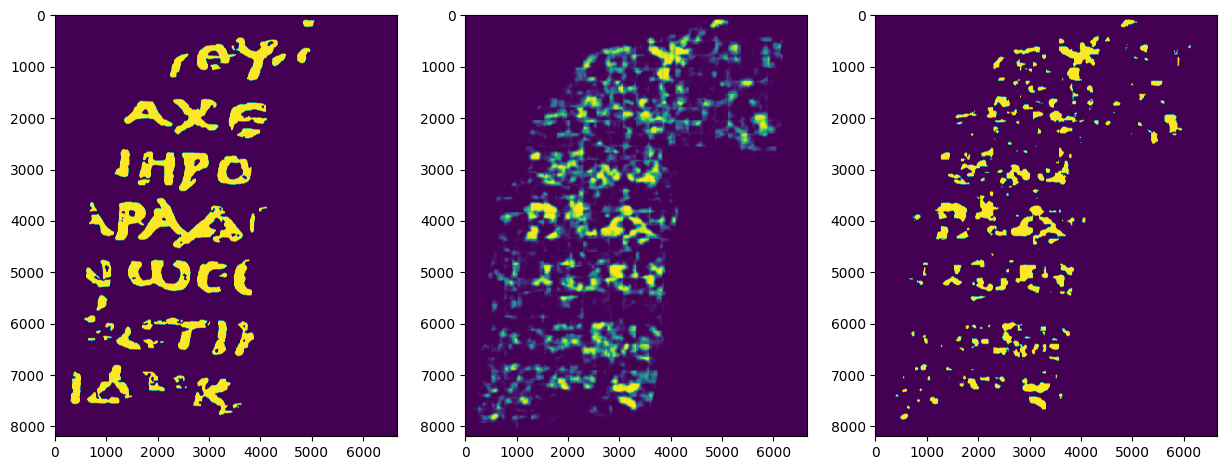

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([42027259.,  2421940.,  1462663.,  1087173.,   880231.,   746852.,
          644397.,   566100.,   503153.,   435951.,   397212.,   380182.,
          347580.,   314633.,   301061.,   296066.,   309687.,   323990.,
          366101.,   713721.]),
 array([1.28757907e-07, 4.99993177e-02, 9.99985066e-02, 1.49997695e-01,
        1.99996884e-01, 2.49996073e-01, 2.99995262e-01, 3.49994451e-01,
        3.99993640e-01, 4.49992829e-01, 4.99992018e-01, 5.49991207e-01,
        5.99990396e-01, 6.49989584e-01, 6.99988773e-01, 7.49987962e-01,
        7.99987151e-01, 8.49986340e-01, 8.99985529e-01, 9.49984718e-01,
        9.99983907e-01]),
 <BarContainer object of 20 artists>)

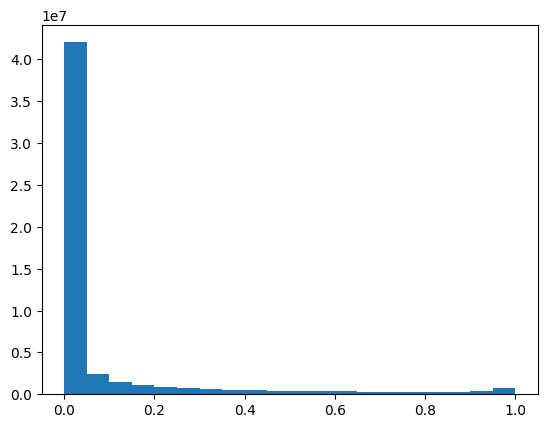

In [34]:
plt.hist(mask_pred.flatten(), bins=20)